**About Dataset**


70000 records and 13 feature columns



Content<br>
The features are given below:<br>
Age | Objective Feature | age | int (days)<br>
Height | Objective Feature | height | int (cm) |<br>
Weight | Objective Feature | weight | float (kg) |<br>
Gender | Objective Feature | gender | categorical code |<br>
Systolic blood pressure | Examination Feature | ap_hi | int |<br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary |<br>
Alcohol intake | Subjective Feature | alco | binary |<br>
Physical activity | Subjective Feature | active | binary |<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [26]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("heart_data.csv")
df.head(5)

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [27]:
#Checking for any null values
print(df.isnull().sum())

index          0
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [28]:
#Converting age in days to age in yrs
df['age'] = np.floor(df['age'] / 365.25).astype(int)
#Creating BMI column using existing weight(Kg) and height(cm) column
df['BMI'] = df['weight'] / ((df['height']/100) ** 2)

df.head(5)

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


Creating a column for hypertension and categorizing people

In [29]:
def classify_blood_pressure(row):
    systolic = row['ap_hi']
    diastolic = row['ap_lo']

    if systolic < 120 and diastolic < 80:
        return 0
    elif 120 <= systolic <= 129 and diastolic < 80:
        return 1
    elif 130 <= systolic <= 139 or (80 <= diastolic <= 89):
        return 2
    elif 179 >= systolic >= 140 or 119 >= diastolic >= 90:
        return 3
    elif systolic >= 180 or diastolic >= 120:
        return 4

# adding hypertension column
df['Hypertension'] = df.apply(classify_blood_pressure, axis=1)
print(df.head(10))

   index  id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0      0   0   50       2     168    62.0    110     80            1     1   
1      1   1   55       1     156    85.0    140     90            3     1   
2      2   2   51       1     165    64.0    130     70            3     1   
3      3   3   48       2     169    82.0    150    100            1     1   
4      4   4   47       1     156    56.0    100     60            1     1   
5      5   8   59       1     151    67.0    120     80            2     2   
6      6   9   60       1     157    93.0    130     80            3     1   
7      7  12   61       2     178    95.0    130     90            3     3   
8      8  13   48       1     158    71.0    110     70            1     1   
9      9  14   54       1     164    68.0    110     60            1     1   

   smoke  alco  active  cardio        BMI  Hypertension  
0      0     0       1       0  21.967120             2  
1      0     0       1   

In [30]:
#Checking for neg values in datasets
def check_neg(column_to_check):
  negative_count = (df[column_to_check] < 0).sum()
  print("Count of negative values in column '{}': {}".format(column_to_check, negative_count))

for col in df.columns:
  check_neg(col)

Count of negative values in column 'index': 0
Count of negative values in column 'id': 0
Count of negative values in column 'age': 0
Count of negative values in column 'gender': 0
Count of negative values in column 'height': 0
Count of negative values in column 'weight': 0
Count of negative values in column 'ap_hi': 7
Count of negative values in column 'ap_lo': 1
Count of negative values in column 'cholesterol': 0
Count of negative values in column 'gluc': 0
Count of negative values in column 'smoke': 0
Count of negative values in column 'alco': 0
Count of negative values in column 'active': 0
Count of negative values in column 'cardio': 0
Count of negative values in column 'BMI': 0
Count of negative values in column 'Hypertension': 0


In [31]:
#sorting the df acc to age
df.sort_values(by='age', ascending=True, inplace=True)

#interpolate the negative ap_lo and ap_high with previous person who has similar age
df['ap_lo'] = df['ap_lo'].mask(df['ap_lo'] < 0, other=pd.NA)
df['ap_hi'] = df['ap_hi'].mask(df['ap_hi'] < 0, other=pd.NA)

df['ap_lo'] = df.groupby('age')['ap_lo'].transform(lambda x: x.interpolate(method='nearest'))
df['ap_hi'] = df.groupby('age')['ap_hi'].transform(lambda x: x.interpolate(method='nearest'))


for col in df.columns:
  check_neg(col)

Count of negative values in column 'index': 0
Count of negative values in column 'id': 0
Count of negative values in column 'age': 0
Count of negative values in column 'gender': 0
Count of negative values in column 'height': 0
Count of negative values in column 'weight': 0
Count of negative values in column 'ap_hi': 0
Count of negative values in column 'ap_lo': 0
Count of negative values in column 'cholesterol': 0
Count of negative values in column 'gluc': 0
Count of negative values in column 'smoke': 0
Count of negative values in column 'alco': 0
Count of negative values in column 'active': 0
Count of negative values in column 'cardio': 0
Count of negative values in column 'BMI': 0
Count of negative values in column 'Hypertension': 0


In [32]:
#unique value
print(df.nunique())

index           70000
id              70000
age                28
gender              2
height            109
weight            287
ap_hi             148
ap_lo             156
cholesterol         3
gluc                3
smoke               2
alco                2
active              2
cardio              2
BMI              3808
Hypertension        5
dtype: int64


**Analysis of datasets**

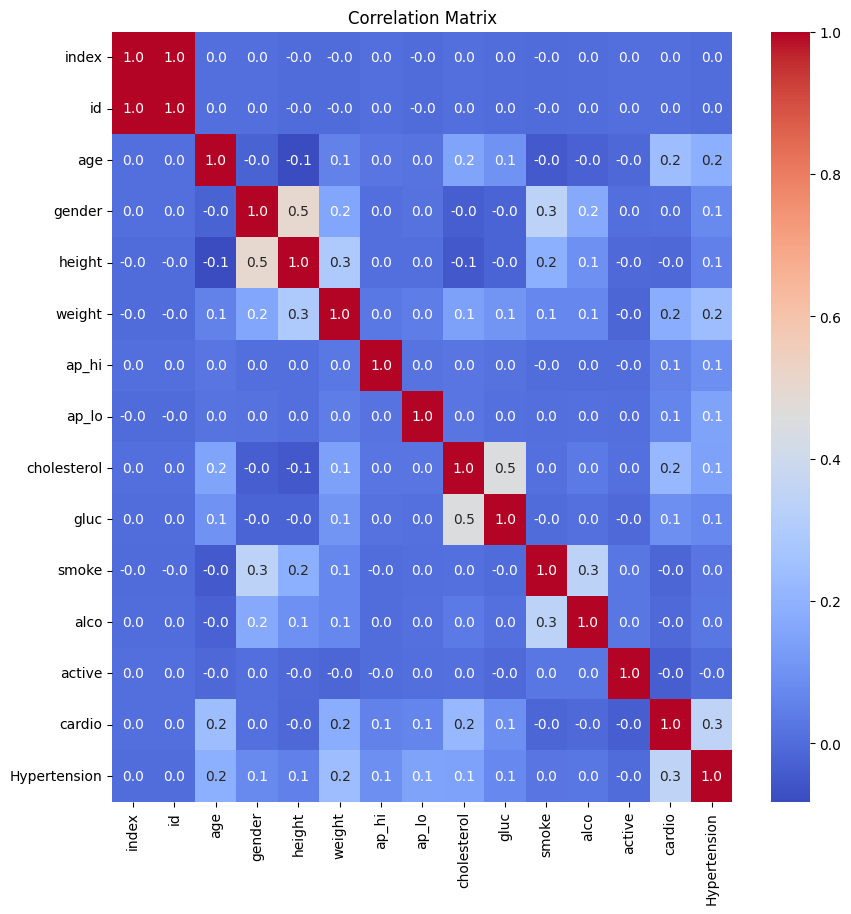

In [6]:
#Creating correlation matrix to measure statistical dependence of each feature.
correlation_matrix = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Matrix')
plt.show()

**Key Insights:**


*  ap_hi and ap_lo (Blood Pressure): These two variables have a perfect correlation (1.0), because they both represent blood pressure readings. This suggest that including both may lead to redundancy in the model; so we have consider to combine them in some meaningful way.
*  weight and BMI: There’s a strong positive correlation (0.8), as BMI is directly calculated using weight and height. This shows that weight is a significant determinant of BMI.
*  cholesterol and gluc (Blood Glucose): There’s a moderate positive correlation (0.5), indicating that high cholesterol is often associated with higher blood glucose levels, which is consistent with known cardiovascular risk factors. Both of these could be important for predicting cardiovascular disease.
*  gender and height: There is a noticeable correlation between gender and height (0.5). This might be due to biological differences in average heights between genders but may not be directly relevant to cardiovascular disease prediction.
*  height and BMI: There is a weak negative correlation (-0.3) between height and BMI. This relationship suggests that, on average, taller individuals may have slightly lower BMI values for a given weight compared to shorter individuals. Although weak, this negative correlation reflects that height inversely affects BMI when weight remains constant.



<Axes: ylabel='count'>

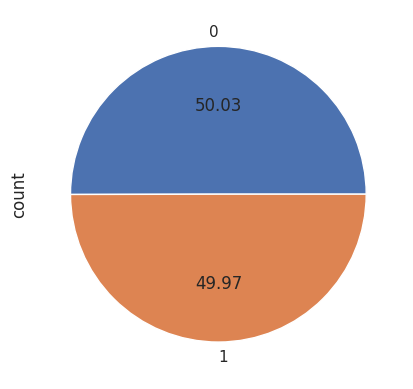

In [33]:
df['cardio'].value_counts().plot(kind='pie',autopct='%.2f')

**Key Insights:**

With approximately 49.97% of individuals with cardiovascular conditions or high cardiovascular risk, indicates a fairly balanced distribution between those at risk and those not at risk.So this dataset has a  balanced target variable which can be advantageous in predictive modeling as it reduces the risk of bias toward one class over the other.

<Axes: ylabel='count'>

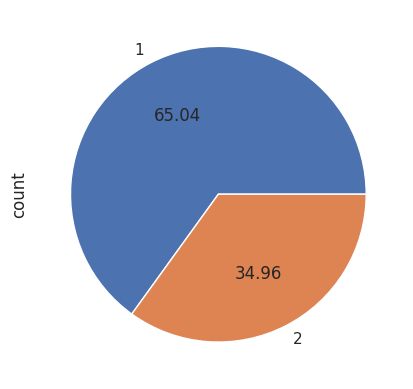

In [34]:
df['gender'].value_counts().plot(kind='pie',autopct='%.2f')

**Key Insights:**

The above pie chart is a skewed gender distribution, with a significantly higher proportion of males. This skewed ratio can impact the interpretation of risk factors, as certain cardiovascular risk factors may differ. For instance, lifestyle or biological factors might make some features more relevant predictors for one gender compared to the other.

(array([4.0000e+00, 6.7230e+03, 1.4930e+04, 2.4622e+04, 2.3721e+04]),
 array([29., 36., 43., 50., 57., 64.]),
 <BarContainer object of 5 artists>)

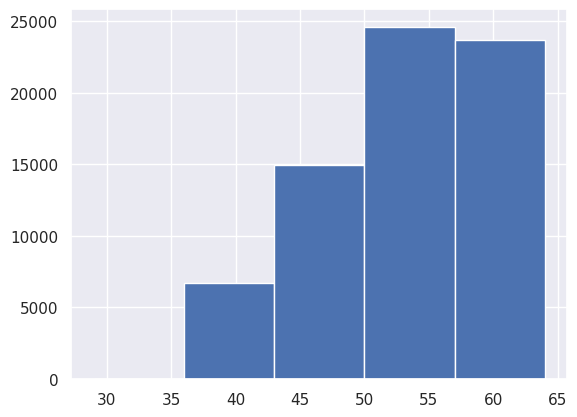

In [35]:
plt.hist(df['age'],bins=5)

**Key Insight:**

This plot shows the distribution of ages (in years). It shows that most individuals in the dataset are in the age range of around 50 to 65, with a lower number of individuals in the younger age brackets. This suggests a dataset skewed towards older adults, which might be relevant for the analysis involves age-related health or lifestyle trends.

<ipython-input-36-7876107a0abe>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['alco'].mean().reset_index()


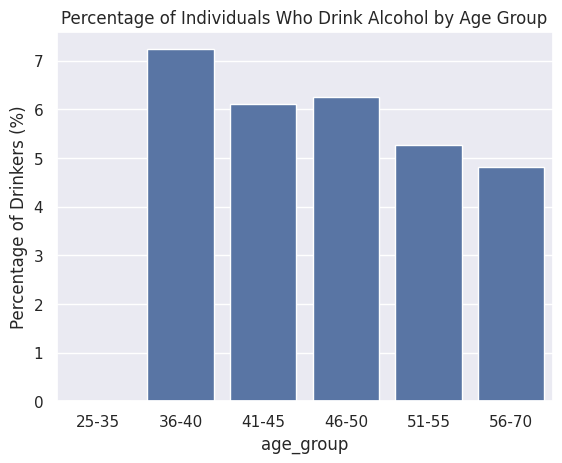

In [36]:
bins = [25, 35, 40, 45, 50, 55, 70]
labels = ['25-35', '36-40', '41-45', '46-50', '51-55', '56-70']

# Create a new column for age groups
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Calculate the percentage of drinkers by age group
percentage_df = df.groupby('age_group')['alco'].mean().reset_index()
percentage_df['percentage'] = percentage_df['alco'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of Drinkers (%)')
plt.title('Percentage of Individuals Who Drink Alcohol by Age Group')
plt.show()

**Insight:**

This bar chart shows that the highest percentage of alcohol consumption occurs in the 36-40 age group. After this peak, alcohol consumption percentage tends to decrease with age. This imply that middle-aged adults are more likely to consume alcohol than older age groups. Understanding this pattern can be valuable in studies related to alcohol's impact on health across different age ranges.

<ipython-input-37-423c2d996c58>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['smoke'].mean().reset_index()


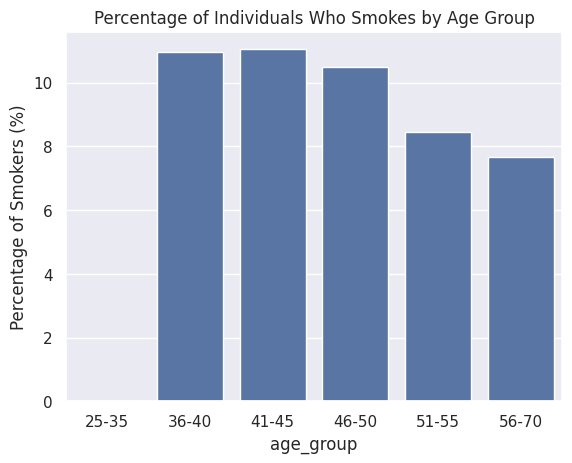

In [37]:
# Calculate the percentage of smokers by age group
percentage_df = df.groupby('age_group')['smoke'].mean().reset_index()
percentage_df['percentage'] = percentage_df['smoke'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of Smokers (%)')
plt.title('Percentage of Individuals Who Smokes by Age Group')
plt.show()

**Insight:**

 Individuals belonging to the age group 36-40 are constitute the highest percentage of smokers and alcohol drinkers. This is likely due to greater amount of stess levels that individuals at this age group are exposed to, which leads to them relying on external stimulants as stress relievers. Such individuals are at a risk for CVD in the next few years depending on the level of their consumption.

<ipython-input-38-b36789811b94>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['cholesterol'].mean().reset_index()


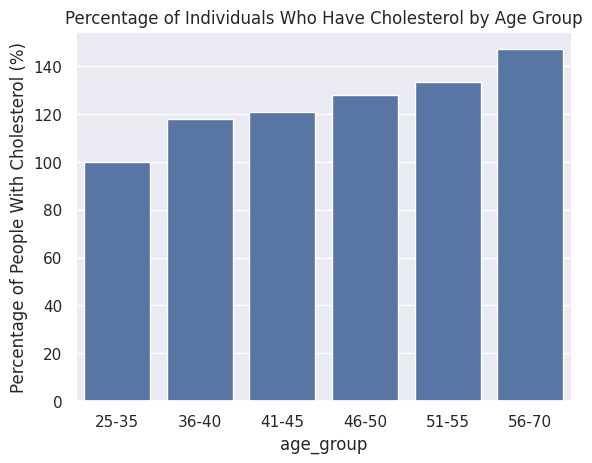

In [38]:
# Calculate the percentage of Cholestrol by age group
percentage_df = df.groupby('age_group')['cholesterol'].mean().reset_index()
percentage_df['percentage'] = percentage_df['cholesterol'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of People With Cholesterol (%)')
plt.title('Percentage of Individuals Who Have Cholesterol by Age Group')
plt.show()

**Insight:**

There is a steady increase in the cholestrol level of individuals as the age group is increasing, which ultimately increases their risk of getting CVD.

<ipython-input-39-cc65205821b1>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['active'].mean().reset_index()


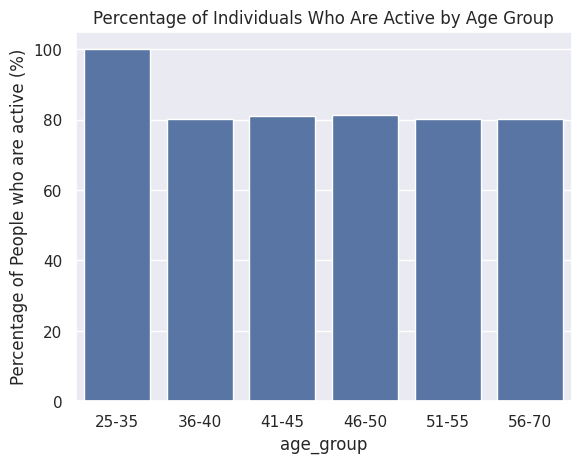

In [39]:
# Calculate the percentage of drinkers by age group
percentage_df = df.groupby('age_group')['active'].mean().reset_index()
percentage_df['percentage'] = percentage_df['active'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of People who are active (%)')
plt.title('Percentage of Individuals Who Are Active by Age Group')
plt.show()
df.drop(['age_group'], axis=1,inplace=True)

**Insight:**

It is observed that the younger generation, particularly the age group 25-35, is more active as compared to the older generations. This can also be one of the reasons why they are less likely to be affected by cardiovascular diseases at their age.

<Axes: xlabel='age', ylabel='Count'>

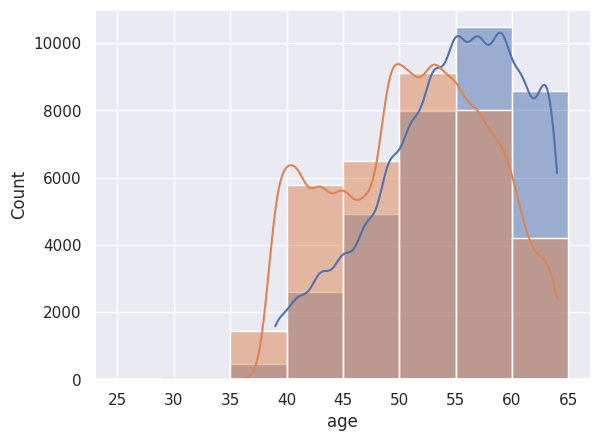

In [40]:
sns.set_theme()
sns.histplot(df[df['cardio'] == 1]['age'], bins=range(25, 66, 5), kde=True) #Blue
sns.histplot(df[df['cardio'] == 0]['age'], bins=range(25, 66, 5), kde=True)  #Orange

**Insight:**

The KDE line smooths out the distribution and gives a visual representation of the underlying probability density function of the age distribution.
It helps you see the overall trend of age distribution.
Interpretation:
Since the bar for the age range 55-60 is the tallest, we can conclude that the highest number of individuals with the cardio condition falls within that age range.
The KDE line shows a peak in a certain age range, it indicates that this age group has a higher density of individuals with the cardio condition,
suggesting potential age-related patterns in cardiovascular health.

Pie charts for visualzing various stages of hypertension across both genders

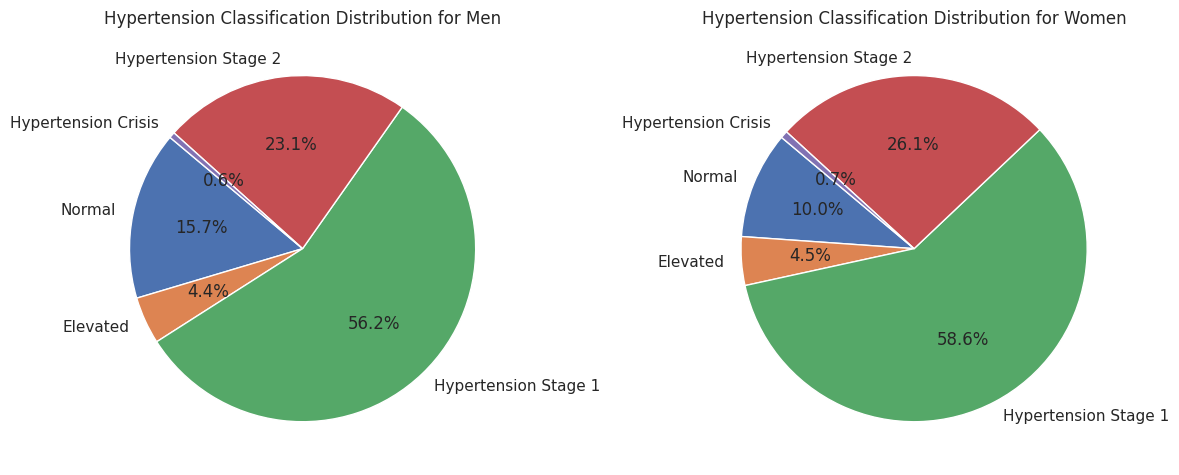

In [41]:
hypertension_counts = df.groupby(['gender', 'Hypertension']).size().unstack()

plt.figure(figsize=(12, 6))

# Creating a pie chart for each gender
for i, gender in enumerate(hypertension_counts.index):
    gender_label = "Women" if gender == 2 else "Men"
    plt.subplot(1, 2, i + 1)
    plt.pie(hypertension_counts.loc[gender], labels=['Normal','Elevated','Hypertension Stage 1','Hypertension Stage 2','Hypertension Crisis'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Hypertension Classification Distribution for {gender_label}')

plt.tight_layout()
plt.show()

**Insight:**


According to the pie charts, we can conclude that women have greater percentage of Hypertension Stage 1 cases as compared to men. They also have more Hypertnesion Stage 2 cases as compared to men. This increases their chances of getting cardiovascular diseases by a narrow margin.

<ipython-input-42-2698ece487d4>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_distribution = df.groupby(['age_group', 'gender', 'Hypertension']).size().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

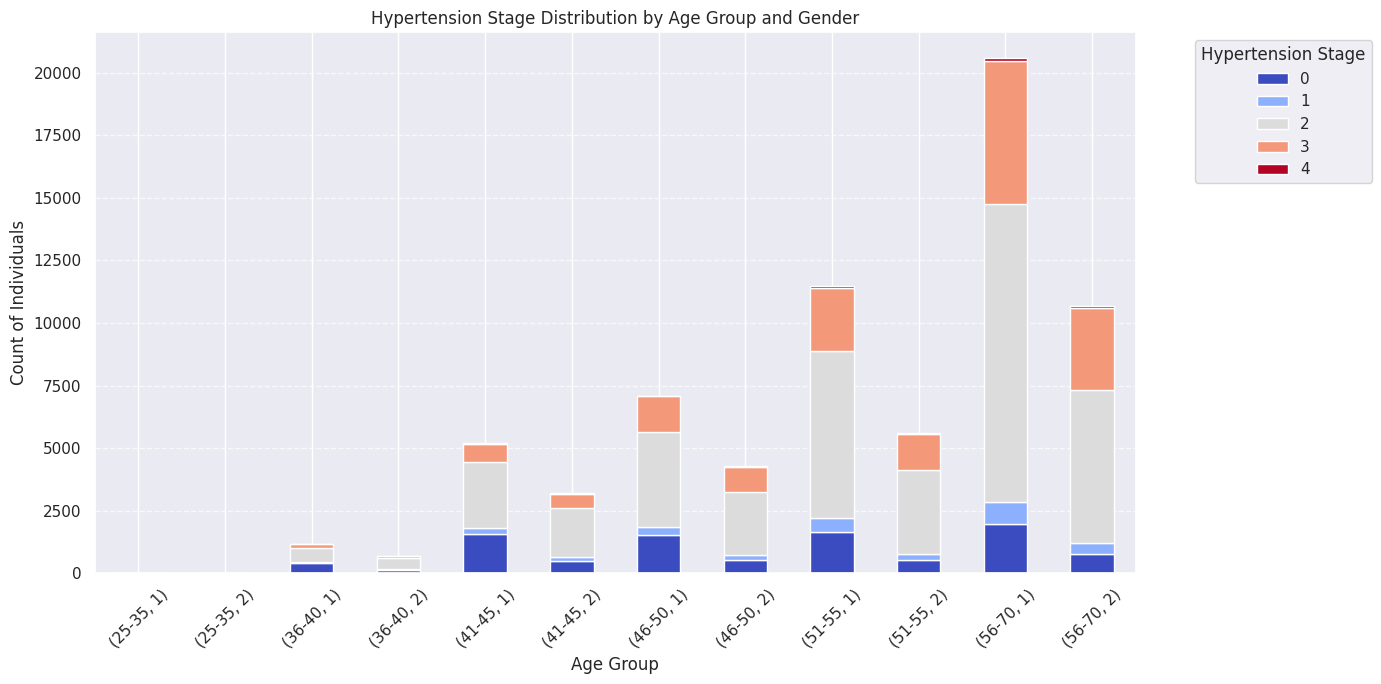

In [42]:
bins = [25, 35, 40, 45, 50, 55, 70]
labels = ['25-35', '36-40', '41-45', '46-50', '51-55', '56-70']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

hypertension_distribution = df.groupby(['age_group', 'gender', 'Hypertension']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
hypertension_distribution.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(14, 7))

plt.title('Hypertension Stage Distribution by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Count of Individuals')
plt.legend(title='Hypertension Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
df.drop(['age_group'],axis=1,inplace=True)

**Insight:**


 The prevalence of hypertension increases with age. This is evident from the increasing height of the stacked bars as we move from younger to older age groups.
The number of individuals in the normal category decreases with age, while the number in the elevated and hypertension stages increases.
In the younger age groups (25-35, 36-40), the majority are still in the normal category.
Starting from the 41-45 age group, we see a significant increase in the number of individuals in the elevated and hypertension stages.
The 56-70 age group has the highest number of individuals in the hypertension stage 2 category.

The increasing prevalence of hypertension with age could be due to various factors like lifestyle changes (e.g., diet, exercise), genetic predisposition, and age-related physiological changes.

**Dectecting the Outlier and Calculating their accuracy score**

Using the describe() to get summary of statistics such as the mean, median, minimum, and maximum values, along with quartiles (25th and 75th percentiles)which could help us spot extreme values that indicate outliers.

Using boxplot visually to get data distribution through quartiles and highlights potential outliers as points outside the "whiskers". This quick visualization helps identify outliers at a glance.

In [43]:
df.describe()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,Hypertension
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,49972.419900,52.803257,1.349571,164.359229,74.205690,128.842157,96.632843,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.556513,1.934429
std,20207.403759,28851.302323,6.762462,0.476838,8.210126,14.395757,153.991179,188.471478,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.091511,0.924615
min,0.000000,0.000000,29.000000,1.000000,55.000000,10.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784,0.000000
25%,17499.750000,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,2.000000
50%,34999.500000,50001.500000,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.374068,2.000000
75%,52499.250000,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.222222,2.000000
max,69999.000000,99999.000000,64.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667,4.000000


<Axes: ylabel='age'>

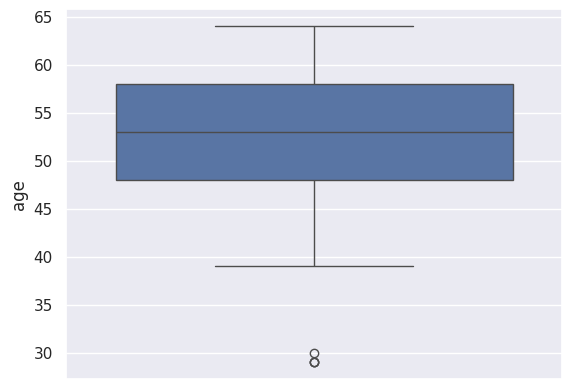

In [44]:
sns.boxplot(df['age'])

<Axes: ylabel='height'>

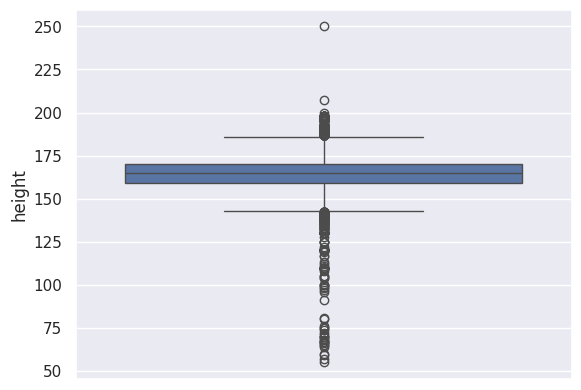

In [ ]:
sns.boxplot(df['height'])

<Axes: ylabel='weight'>

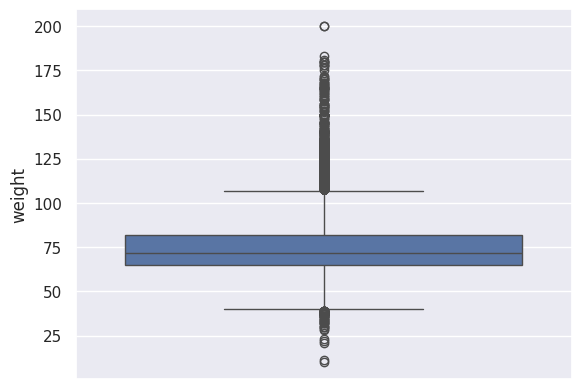

In [ ]:
sns.boxplot(df['weight'])

<Axes: ylabel='BMI'>

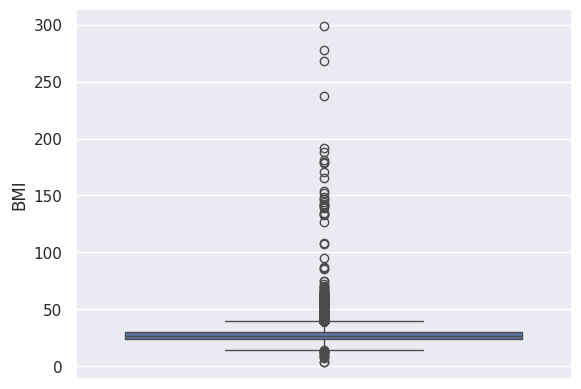

In [ ]:
sns.boxplot(df['BMI'])

**Z-scoring Technique:**

z-scores can help identify extreme measurements (e.g., unusually high cholesterol or blood pressure readings) that may skew results if left untreated. By detecting these outliers, we can decide whether to retain, modify, or remove them, depending on their relevance with our analysis.








In [45]:
# Checking for outliers in specific columns using the Z-score method.
column=['age','height','weight','ap_lo','ap_hi','BMI']
# Calculate boundary values (using Z-score):
# For each column, it calculates the mean (average) and standard deviation (a measure of spread).
# The highest and lowest boundaries are based on the Z-score method.
# In a normal distribution, about 99.7% of the data falls within ±3 standard deviations from the mean, so values outside this range are considered outliers.
for cols in column:
    print(f"\n{cols}:")
    # Finding the boundary values
    high=df[cols].mean() + 3*df[cols].std();
    low=df[cols].mean() - 3*df[cols].std()
    print("Highest allowed",high)
    print("Lowest allowed",low)
    # Finding the outliers
    print(df[(df[cols] > high) | (df[cols] < low)])


age:
Highest allowed 73.09064227828898
Lowest allowed 32.5158720074253
       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
6219    6219   8850   29       1     175    59.0  120.0   80.0            1   
22343  22343  31922   29       2     175    92.0  100.0   60.0            1   
30666  30666  43842   29       1     159    59.0  120.0   80.0            1   
55905  55905  79749   30       1     160    59.0  110.0   70.0            1   

       gluc  smoke  alco  active  cardio        BMI  Hypertension  
6219      1      0     0       1       0  19.265306             2  
22343     1      0     0       1       0  30.040816             0  
30666     1      0     0       1       0  23.337684             2  
55905     1      0     0       1       0  23.046875             0  

height:
Highest allowed 188.98960766504325
Lowest allowed 139.72884947781387
       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
36642  36642  52361   39       2   

**InterQuartile Technique:**

The IQR method is less sensitive to extreme values compared to Z-score. It’s particularly useful for non-normally distributed data because it doesn’t rely on the mean and standard deviation, which can be skewed by outliers.
By applying the IQR method, we can detect and potentially handle outliers without assuming that the data follows a normal distribution. This helps in maintaining the integrity of the analysis, especially when dealing with skewed data.

In [46]:
# IQR is the difference between Q3 and Q1 (IQR = Q3 - Q1). It measures the "spread" of the middle 50% of the data.
# The code calculates and prints the IQR for each column.
column=['age','height','weight','ap_lo','ap_hi','BMI']
for cols in column:
    print(f"\n{cols}:")
    # Finding the IQR
    Q1= df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    print(f"25percentile: {Q1}")
    print(f"75percentile: {Q3}")
    iqr = Q3-Q1
    print(f"IQR: {iqr}")
    upper_limit = Q3 + 1.5 * iqr
    lower_limit = Q1 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    print(df[(df[cols] >= lower_limit) & (df[cols] <= upper_limit)])


age:
25percentile: 48.0
75percentile: 58.0
IQR: 10.0
Upper limit 73.0
Lower limit 33.0
       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
47373  47373  67661   39       1     168    61.0  100.0   80.0            1   
62801  62801  89674   39       2     182    62.0  130.0   60.0            1   
16802  16802  24010   39       1     155    54.0  120.0   80.0            1   
62781  62781  89645   39       2     168    70.0  120.0   80.0            1   
21482  21482  30691   39       2     167    72.0  110.0   70.0            1   
...      ...    ...  ...     ...     ...     ...    ...    ...          ...   
52939  52939  75519   64       1     162   110.0  140.0   90.0            3   
16318  16318  23314   64       1     166    68.0  140.0   90.0            3   
61161  61161  87316   64       1     152    70.0  170.0   80.0            1   
52740  52740  75241   64       1     170    76.0  120.0   80.0            1   
27304  27304  39043   64       1     160   

**Accuracy score after removing the outlier using z-score**

In [47]:
column=['weight','ap_lo','ap_hi']
zscore_df=df
#Filter Out Outliers, keeping only the rows where values in the column are within the high and low bounds (i.e., not outliers).
# The resulting dataset, new_df, has outliers removed for the selected columns.
for cols in column:
    # Finding the boundary values
    high=zscore_df[cols].mean() + 3*zscore_df[cols].std();
    low=zscore_df[cols].mean() - 3*zscore_df[cols].std()
    # Triming the outliers
    zscore_df = zscore_df[(zscore_df[cols] < high) & (zscore_df[cols] > low)]
print(zscore_df.head(5))

# Creating two separate train-test splits for two versions of the dataset:
# Original Dataset (df):Splits df into X_train, X_test, y_train, and y_test, where X contains features (everything except the cardio column) and y is the target variable (cardio column).
# Outlier-Removed Dataset (zscore_df):Splits new_df into X_train_scaled, X_test_scaled, y_train_scaled, and y_test_scaled, following the same format as the original dataset split.
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1),
                                                    df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)
X_train_no_outlier , X_test_no_outlier,y_train_no_outlier,y_test_no_outlier =train_test_split(zscore_df.drop('cardio', axis=1),
                                                    zscore_df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)
lr = LogisticRegression()
lr_no_outlier = LogisticRegression()
# Fit the models
lr.fit(X_train, y_train)
lr_no_outlier.fit(X_train_no_outlier, y_train_no_outlier)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_no_outlier = lr_no_outlier.predict(X_test_no_outlier)

# Evaluate if removing outliers (using Z-scoring) improves the model’s accuracy in predicting the target variable (cardio).
print("Actual Accuracy:", accuracy_score(y_test, y_pred))
print("Zscoring Accuracy:", accuracy_score(y_test_no_outlier, y_pred_no_outlier))

       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
6219    6219   8850   29       1     175    59.0  120.0   80.0            1   
22343  22343  31922   29       2     175    92.0  100.0   60.0            1   
30666  30666  43842   29       1     159    59.0  120.0   80.0            1   
55905  55905  79749   30       1     160    59.0  110.0   70.0            1   
47373  47373  67661   39       1     168    61.0  100.0   80.0            1   

       gluc  smoke  alco  active  cardio        BMI  Hypertension  
6219      1      0     0       1       0  19.265306             2  
22343     1      0     0       1       0  30.040816             0  
30666     1      0     0       1       0  23.337684             2  
55905     1      0     0       1       0  23.046875             0  
47373     1      0     0       1       0  21.612812             2  


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual Accuracy: 0.6895
Zscoring Accuracy: 0.7098331870061457


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



**Insight:**

This slight increase in accuracy indicate that the model generalize better on the test data. By filtering out extreme values that could distort the analysis, the model can focus on patterns that are more representative of the majority of data points.

**Accuracy score after removing the outlier using IQR**

In [48]:
#Checking the accuracy score after removing the outlier using IQR
column=['ap_lo','ap_hi']
IQR_df=df
for cols in column:
    # Finding the IQR
    Q1= IQR_df[cols].quantile(0.25)
    Q3 = IQR_df[cols].quantile(0.75)
    iqr = Q3-Q1
    upper_limit = Q3 + 1.5 * iqr
    lower_limit = Q1 - 1.5 * iqr
    IQR_df=IQR_df[(IQR_df[cols] >= lower_limit) & (IQR_df[cols] <= upper_limit)]
# It splits both the original data (df) and the cleaned data (IQR_df) into training and testing sets.
# X_train and y_train are the training features and labels from the original data, while X_train_scaled and y_train_scaled are from the cleaned data.
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1),
                                                    df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)
X_train_no_outlier , X_test_no_outlier,y_train_no_outlier,y_test_no_outlier =train_test_split(IQR_df.drop('cardio', axis=1),
                                                    IQR_df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)
lr = LogisticRegression()
lr_no_outlier = LogisticRegression()
# Fit the models
lr.fit(X_train, y_train)
lr_no_outlier.fit(X_train_no_outlier, y_train_no_outlier)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_no_outlier = lr_no_outlier.predict(X_test_no_outlier)

# Evaluate if removing outliers (using Z-scoring) improves the model’s accuracy in predicting the target variable (cardio).
print("Actual Accuracy:", accuracy_score(y_test, y_pred))
print("IQR Accuracy:", accuracy_score(y_test_no_outlier, y_pred_no_outlier))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual Accuracy: 0.6895
IQR Accuracy: 0.7027592621299024


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The Interquartile Range (IQR) technique shows a slight improvement over the actual accuracy, with an increase of about 0.0132%. This suggests that using IQR for handling outliers or data scaling has had a positive effect on the model's performance.

**Comparison:**

Both IQR and Zscoring techniques improve upon the actual accuracy, but Zscoring shows a more significant boost.
IQR provides a modest improvement, indicating it may be effective for certain types of data distributions or outlier management.Zscoring, however, appears to be more effective in optimizing the model's performance, likely due to its ability to standardize features, making them comparable and improving convergence during model training.

Both techniques have merit, but Zscoring offers a more substantial enhancement to the model's accuracy

**Scaling our Dataset:**

**Min-Max Scaling Method:**



It is used to scale the data so as to bring them to a particular range ie [0,1] for consistency in model. It makes use of the LogisticRegression Model to make predictions. Another way of scaling data is Absolute Maximum Scaling Method which brings the dataset to the range [-1,1]. It is used when the dataset has negative and positive values. Since we have already handled negative values in the previous sections, there would be no point in applying this method as it would bring the positive values to the range [0,1] which is already achieved by Min-Max Scaling Method.

In [49]:
#Checking the accuracy score after removing the outlier using z-score
column=['weight','ap_lo','ap_hi']
minmax_df=df
#Filter Out Outliers, keeping only the rows where values in the column are within the high and low bounds (i.e., not outliers).
# The resulting dataset, new_df, has outliers removed for the selected columns.
for cols in column:
    # Finding the boundary values
    high=minmax_df[cols].mean() + 3*minmax_df[cols].std()
    low=minmax_df[cols].mean() - 3*minmax_df[cols].std()
    # Triming the outliers
    minmax_df = minmax_df[(minmax_df[cols] < high) & (minmax_df[cols] > low)]
#cardio is the target (dependent) variable so removing that column while maximum absolute scaling
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), df['cardio'], test_size=0.2, random_state=42)

min_max_scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = min_max_scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = min_max_scaler.transform(X_test)

# Converting the scaled data back to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lr = LogisticRegression()
lr_scaled = LogisticRegression()

# Fiting the model on the original and scaled data
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train)

#making predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluating the accuracy of both models
print("Actual Accuracy without scaling:", accuracy_score(y_test, y_pred))
print("Accuracy after Min-Max scaling:", accuracy_score(y_test, y_pred_scaled))

X_train, X_test, y_train, y_test = train_test_split(minmax_df.drop('cardio', axis=1), minmax_df['cardio'], test_size=0.2, random_state=42)

min_max_scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = min_max_scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = min_max_scaler.transform(X_test)

# Converting the scaled data back to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lr = LogisticRegression()
lr_scaled = LogisticRegression()

# Fiting the model on the original and scaled data
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train)

#making predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluating the accuracy of both models
print("Actual Accuracy without scaling without outliers:", accuracy_score(y_test, y_pred))
print("Accuracy after Min-Max scaling without outliers:", accuracy_score(y_test, y_pred_scaled))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual Accuracy without scaling: 0.6895
Accuracy after Min-Max scaling: 0.6965714285714286


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual Accuracy without scaling without outliers: 0.7098331870061457
Accuracy after Min-Max scaling without outliers: 0.7246853965466784


**Graphs of features-height and weight after min-max scaling**

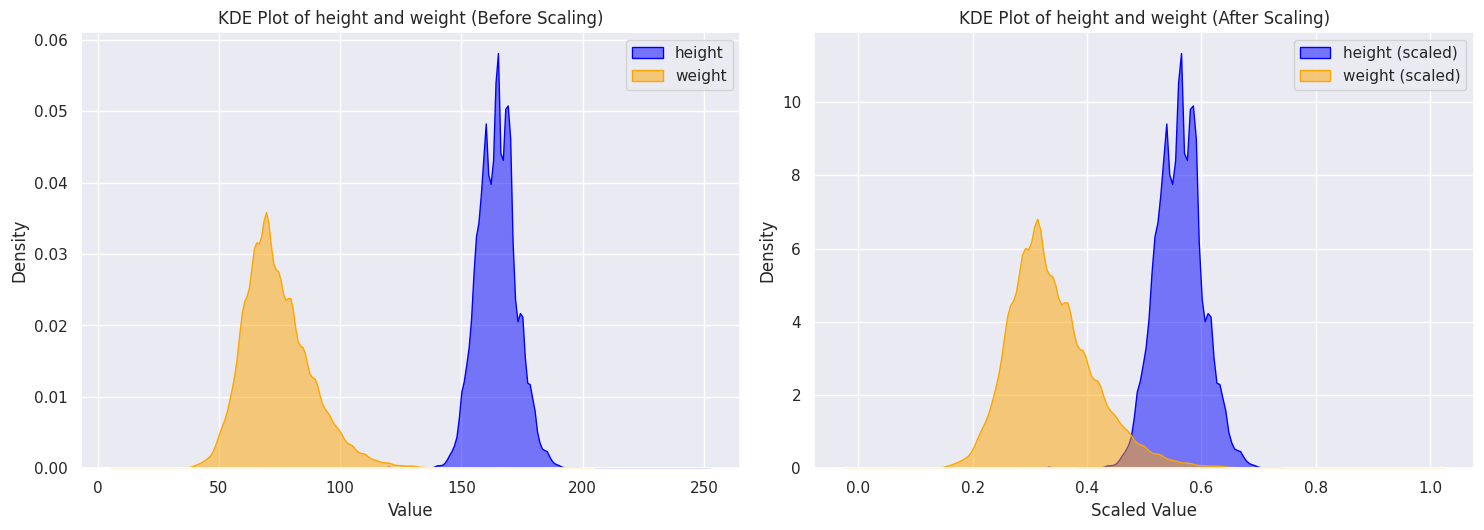

In [50]:
features = df[['height', 'weight']]

# Scale the features-height and weight using Min-Max Scaling
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=['height', 'weight'])

#plot
plt.figure(figsize=(15, 10))

#using KDE plot for original data
plt.subplot(2, 2, 1)
sns.kdeplot(features['height'], label='height', fill=True, color='blue', alpha=0.5)
sns.kdeplot(features['weight'], label='weight', fill=True, color='orange', alpha=0.5)
plt.title('KDE Plot of height and weight (Before Scaling)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

#using KDE plot for scaled data
plt.subplot(2, 2, 2)
sns.kdeplot(features_scaled_df['height'], label='height (scaled)', fill=True, color='blue', alpha=0.5)
sns.kdeplot(features_scaled_df['weight'], label='weight (scaled)', fill=True, color='orange', alpha=0.5)
plt.title('KDE Plot of height and weight (After Scaling)')
plt.xlabel('Scaled Value')
plt.ylabel('Density')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

**Inference:**


**Before Scaling:**



Height(unscaled): The height distribution appears to be roughly normal, with a peak around 170-180 units and a relatively narrow spread. This suggests that most individuals in the dataset have heights within this range, with fewer individuals having significantly taller or shorter heights.
Weight(unscaled):
The weight distribution is skewed to the right, with a longer tail towards higher values. This indicates that while there are many individuals with lower weights, there are also a significant number of individuals with much higher weights.

**After Scaling:**

Height (scaled):
The scaled height distribution now appears more symmetrical, with a peak around 0.6-0.7. This suggests that the scaling process has transformed the height values to a more uniform scale.
Weight (scaled):
The scaled weight distribution is also more symmetrical than before, with a peak around 0.4-0.5. The right tail has been compressed, suggesting that the scaling process has reduced the impact of extreme weight values.

**Conclusion:**
Although min-max scaling was achieved successfully, the accuracy evaluated after scaling was reduced. We can conclude that z-scaling is the most appropriate way of normalizing our dataset as the accuracy is better.

**Doing Standard Scaling:**

It normalizes the features of a dataset, ensuring they have a mean of zero and a standard deviation of one. This process helps eliminate bias caused by varying scales of features, allowing algorithms to converge more effectively and improving model performance.Overall, promoting more reliable and efficient training of machine learning models.

In [51]:
from sklearn.preprocessing import StandardScaler
#Scaling using dataset with outliers
# The train_test_split function divides the dataset (df) into two parts:
# Training Set (X_train, y_train) and Testing Set (X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1),df['cardio'],test_size=0.2,random_state=42)
X_train.shape, X_test.shape
scaler = StandardScaler() #creates an object that will help in scaling the data.

# scaler.fit() learns the mean and standard deviation from the training set.
scaler.fit(X_train)

# transform train and test sets then apply this scaling to both the training and testing sets, transforming them into standardized data.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lr = LogisticRegression()
lr_scaled = LogisticRegression()
# Fit the models
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluate accuracy
print("Actual Accuracy:", accuracy_score(y_test, y_pred))
print("Scaled Accuracy without outlier:", accuracy_score(y_test, y_pred_scaled))

Actual Accuracy: 0.6895
Scaled Accuracy without outlier: 0.7165714285714285


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


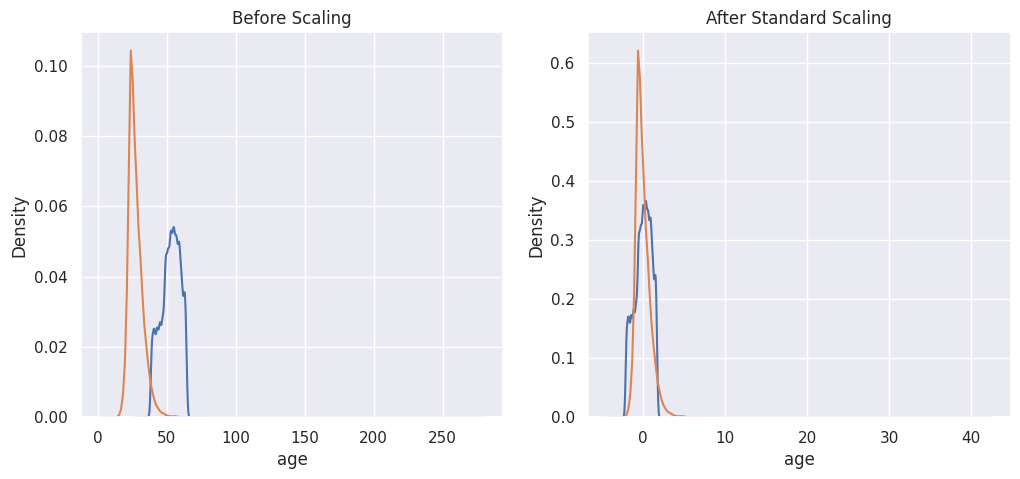

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['age'], ax=ax1)
sns.kdeplot(X_train['BMI'], ax=ax1)

# after scaling
ax2.set_title('After Standard Scaling')
sns.kdeplot(X_train_scaled['age'], ax=ax2)
sns.kdeplot(X_train_scaled['BMI'], ax=ax2)
plt.show()

**Insight:**

In the Before Scaling plot, age and BMI are shown in their original units, where they may have vastly different scales. For instance, age might range between 25-65, while BMI might have a much smaller range. This difference in scale can affect how algorithms interpret these features.

In the After Standard Scaling plot, the values are normalized, and both age and BMI have a mean close to 0 with a standard deviation of 1. This standardization makes both distributions comparable in terms of scale without changing the original shape or relative density of the data points.

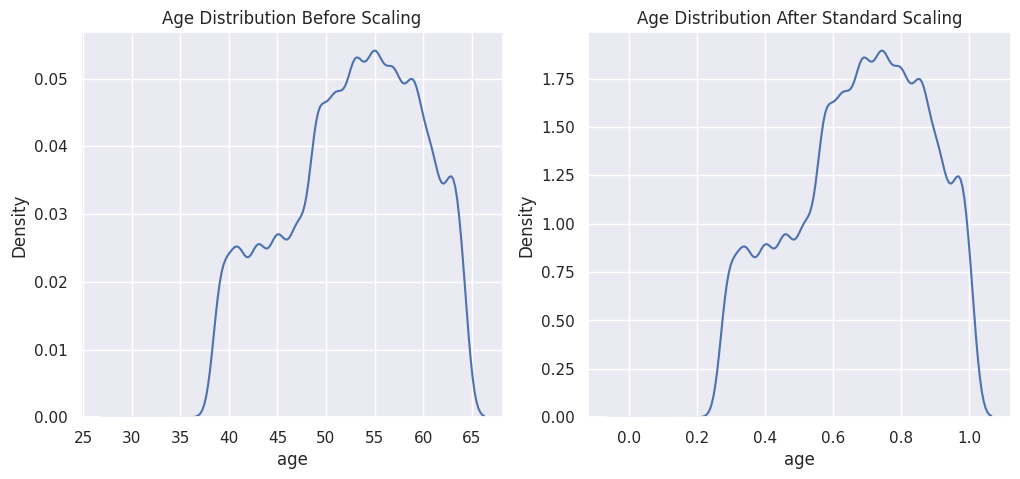

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Age Distribution Before Scaling')
sns.kdeplot(X_train['age'], ax=ax1)

# after scaling
ax2.set_title('Age Distribution After Standard Scaling')
sns.kdeplot(X_train_scaled['age'], ax=ax2)
plt.show()

Before Scaling: The age distribution is in its original form, with values spread out over a large range. This shows the natural skew and concentration of values in the data.

After Scaling: The distribution is transformed to have a mean of 0 and unit variance, while preserving its shape. This scaled distribution facilitates machine learning models by making the feature comparable in scale to other features.

 Although the scale has changed, the overall shape and pattern of the distribution remain similar. This is important because it shows that scaling does not distort the relative relationships between data points. Instead, it only normalizes the values so that they are easier for the model to work with, making the distribution comparable to other scaled features.

**Scaling using dataset without outliers(weight,ap_lo,ap_hi)**

In [53]:
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop('cardio', axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)
X_train.shape, X_test.shape
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
np.round(X_train.describe(), 1)
np.round(X_train_scaled.describe(), 1)

lr = LogisticRegression()
lr_scaled = LogisticRegression()
# Fit the models
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluate accuracy
print("Actual Accuracy without outlier:", accuracy_score(y_test, y_pred))
print("Scaled Accuracy without outlier:", accuracy_score(y_test, y_pred_scaled))

Actual Accuracy without outlier: 0.7098331870061457
Scaled Accuracy without outlier: 0.7254170324846356


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Applying Feature Reduction Technique:



**PCA:**


Principal Component Analysis (PCA) is a technique for reducing the number of features in a dataset while preserving as much of its original information as possible. It does this by identifying patterns in the data, specifically the directions (or "principal components") along which the data varies the most. These principal components are essentially new axes that capture the majority of the dataset's variance in a simplified form. By projecting the data onto just a few of these principal components, PCA reduces the complexity of the data, discarding less important information and keeping only the most essential parts.

In [54]:
# Applying PCA on Standard Scaled data
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
np.round(X_train.describe(), 1)
np.round(X_train_scaled.describe(), 1)

# Performing PCA on one of the sets
pca = PCA(n_components = 5)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance for training data: {explained_variance.sum()}")

X_test_scaled_pca = pca.fit_transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance for testing data: {explained_variance.sum()}")

# Perfoming Logistic regression on set with PCA and without PCA
lr_test_scaled = LogisticRegression()
lr_test_scaled_pca = LogisticRegression()

lr_test_scaled.fit(X_train_scaled, y_train)
lr_test_scaled_pca.fit(X_train_scaled_pca, y_train)

#making predictions
y_pred_scaled = lr_test_scaled.predict(X_test_scaled)
y_pred_scaled_pca  = lr_test_scaled_pca.predict(X_test_scaled_pca)

# Evaluating the accuracy of both models
print("Actual Accuracy Z-Scaled with PCA:", accuracy_score(y_test, y_pred_scaled_pca))
print("Actual Accuracy Z-Scaled without PCA:",accuracy_score(y_test, y_pred_scaled))
predictions_binary = (y_pred_scaled > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Explained variance for training data: 0.6412594164490382
Explained variance for testing data: 0.6447296859991831
Actual Accuracy Z-Scaled with PCA: 0.7201492537313433
Actual Accuracy Z-Scaled without PCA: 0.7254170324846356
Accuracy: 0.7254
Precision: 0.7522
Recall: 0.6660
F1 Score: 0.7065
Confusion Matrix:
[[5399 1488]
 [2265 4516]]


**Inference**

**PCA on Stardard Scaler Data**

PCA on Z-Scale data will provide better max accuracy at 72% but the explained variance is very low at 64. We have to provide 7 components to get the maximum accuracy and upto 10 components to get an acceptable explained variance value, Which is a lot more than the ideal maximum of 3 components. The other components have similiar values due to the balanced nature of the dataset with a bias towards precision

In [55]:
# Applying PCA on Min-Max Scaled data
min_max_scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = min_max_scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = min_max_scaler.transform(X_test)

# Converting the scaled data back to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Performing PCA on one of the sets
pca = PCA(n_components = 8)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance for training data: {explained_variance.sum()}")

X_test_scaled_pca = pca.fit_transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance for testing data: {explained_variance.sum()}")

# Perfoming Logistic regression on set with PCA and without PCA
lr_test_scaled = LogisticRegression()
lr_test_scaled_pca = LogisticRegression()

lr_test_scaled.fit(X_train_scaled, y_train)
lr_test_scaled_pca.fit(X_train_scaled_pca, y_train)

#making predictions
y_pred_scaled = lr_test_scaled.predict(X_test_scaled)
y_pred_scaled_pca  = lr_test_scaled_pca.predict(X_test_scaled_pca)

# Evaluating the accuracy of both models
print("Actual Accuracy Z-Scaled with PCA:", accuracy_score(y_test, y_pred_scaled_pca))
print("Actual Accuracy Z-Scaled without PCA:",accuracy_score(y_test, y_pred_scaled))
predictions_binary = (y_pred_scaled > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Explained variance for training data: 0.9424257941118594
Explained variance for testing data: 0.9428420300783802
Actual Accuracy Z-Scaled with PCA: 0.7007609013754755
Actual Accuracy Z-Scaled without PCA: 0.7246853965466784
Accuracy: 0.7247
Precision: 0.7475
Recall: 0.6720
F1 Score: 0.7078
Confusion Matrix:
[[5348 1539]
 [2224 4557]]


**Inference**


**PCA on Min-Max Scaled data**

PCA on Min-Max Scaled data will provide a sufficient Explained variance at 8 components but its accuracy is quite low at 70%. there is a noticable dip in accuracy compared to without PCA. we also require 8 components here for ideal results, which is more than the ideal maximum of 3. There is a similiar result with the other metrics as well

**Result**

PCA is a possible way for feature extraction within the data

**SVD:**

Singular Value Decomposition (SVD) is a powerful linear algebra technique used for dimensionality reduction. It breaks down a matrix into three components (U, Σ, V), which allows us to understand and keep the most significant patterns in the data while discarding noise or less critical information.Models on SVD data often generalize better and may perform well in terms of accuracy by reducing overfitting risks associated with many redundant or noisy features.

First Combining the X_train_scaled and X_test_scaled into one DataFrame

In [56]:
StdScalar_withoutOutlier = pd.concat([X_train_scaled, X_test_scaled], ignore_index=True)
print(StdScalar_withoutOutlier.describe())

              index            id           age        gender        height  \
count  68339.000000  68339.000000  68339.000000  68339.000000  68339.000000   
mean       0.499870      0.499598      0.679836      0.348044      0.560657   
std        0.288635      0.288468      0.193285      0.476354      0.041762   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.249786      0.249870      0.542857      0.000000      0.533333   
50%        0.499857      0.499840      0.685714      0.000000      0.564103   
75%        0.749543      0.748380      0.828571      1.000000      0.589744   
max        1.000014      1.000010      1.000000      1.000000      1.000000   

             weight         ap_hi         ap_lo   cholesterol          gluc  \
count  68339.000000  68339.000000  68339.000000  68339.000000  68339.000000   
mean       0.489232      0.302509      0.135024      0.180761      0.111649   
std        0.155549      0.044882      0.016979    

In [57]:
 # SVD for dimensionality reduction on Scaled Dataset
from sklearn.decomposition import TruncatedSVD
# Transforming the data by projecting it onto the two singular vectors
svd = TruncatedSVD(n_components=2)
reduced_data = svd.fit_transform(StdScalar_withoutOutlier )
print(f"Component=2:",end=' ')
print(svd.explained_variance_ratio_)


# Transforming the data by projecting it onto the five singular vectors
svd = TruncatedSVD(n_components=5)
reduced_data = svd.fit_transform(StdScalar_withoutOutlier )
print(f"Component=5:",end=' ')
print(svd.explained_variance_ratio_)

# Transforming the data by projecting it onto the ten singular vectors
svd = TruncatedSVD(n_components=10)
reduced_data = svd.fit_transform(StdScalar_withoutOutlier )
print(f"Component=10:",end=' ')
print(svd.explained_variance_ratio_)

Component=2: [0.11383137 0.23670077]
Component=5: [0.11383137 0.23670077 0.16309814 0.14990038 0.09584938]
Component=10: [0.11383137 0.23670077 0.16309814 0.14990038 0.09584938 0.07498003
 0.05147799 0.03944927 0.03853375 0.02573092]


With only 2 components, the explained variance is around 32.43% . This suggests that these two components capture a limited amount of the total information, meaning that reducing the data to 2 components could lose significant detail from the original features.

When the number of components increases to 5, the cumulative explained variance rises to about 64.2% (adding the first five values). This level of variance suggests a better approximation of the dataset, though it's still below the threshold (typically 80-90%) that would indicate strong retention of information with minimal loss.

By increasing the components to 10, the explained variance captures around 92.3% of the variability in the dataset. This high explained variance indicates that 10 components retain most of the important information in the original data, allowing for dimensionality reduction while preserving the structure.

In [58]:
# Checking the accuracy of SVD with 10 components with scaled data
svd = TruncatedSVD(n_components=10)
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd = svd.transform(X_test_scaled)

#Train the models
model_scaled = LogisticRegression()
model_svd = LogisticRegression()

model_scaled.fit(X_train_scaled, y_train)
model_svd.fit(X_train_svd, y_train)

# Evaluate the accuracy on both datasets
print("Accuracy on scaled dataset:", model_scaled.score(X_test_scaled, y_test))
print("Accuracy on SVD dataset:", model_svd.score(X_test_svd, y_test))

Accuracy on scaled dataset: 0.7246853965466784
Accuracy on SVD dataset: 0.6943956687152473


The marginal difference in accuracy suggests that the SVD-reduced dataset retains a significant amount of information, but it does not quite capture as much predictive power as the original scaled features. This might be expected, especially if the most informative features are spread out across multiple components.

The SVD dataset offers dimensionality reduction, which can be beneficial in terms of model complexity and computational efficiency. However, in this case, it seems that using the full set of scaled features provides slightly better performance.

**LDA**<br>
Linear Discriminant Analysis is a feature reduction technique used in various domains for its ability to handle classification tasks effectively while reducing dimensionality. It emphasizes maximizing class separability, making it an excellent choice for scenarios where understanding the relationship between different classes is crucial.<br>
In our dataset, the target variable is cardio which has 2 unique values-0 and 1. Hence, n_components=1 i.e(unique-1)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train_scaled, y_train)

# Transform the training and test data
X_train_lda = lda.transform(X_train_scaled)
X_test_lda = lda.transform(X_test_scaled)

# Fit Logistic Regression on LDA transformed data for finding the accuracy
lr_lda = LogisticRegression()
lr_lda.fit(X_train_lda, y_train)

# Making predictions with the LDA model
y_pred_lda = lr_lda.predict(X_test_lda)

# Calculating accuracy for LDA model
lda_accuracy = accuracy_score(y_test, y_pred_lda)

# Explained variance ratio for the LDA components
explained_variance = lda.explained_variance_ratio_

print("Explained Variance Ratios for LDA components:", explained_variance)
print("LDA Model Accuracy:", lda_accuracy)
lda = LinearDiscriminantAnalysis(n_components=1)


Explained Variance Ratios for LDA components: [1.]
LDA Model Accuracy: 0.7239537606087211


**Inference:**<br>
Explained variance-It is a statistical measure used to quantify the amount of variability in a dataset that can be attributed to a particular component or feature.
The explained variance will be 1 always because n_components=1.<br>
The accuracy, although better than the SVD, is similar to the accuracy of the PCA Model. It means that the model correctly classified about 72.45% of the instances in the test dataset.

**Conclusion:**<br>
After using various scaling techniques such as zscore method, outlier removal method and min-max scaling method and feature reduction techniques such as PCA, SVD and LDA, we come to the conclusion that we do not require feature reduction techniques on our dataset as they only decrease the accuracy of the model. We will be sticking the StandardScaling done on zscore dataset.

**Polynomial Regression :**<br>


Polynomial regression is a form of regression analysis where the relationship between the independent variable (ap_lo,ap_hi, etc) and the dependent variable (cardio) is modeled as an nth degree polynomial. This technique is particularly useful when the relationship between the variables is not linear. <br>
In simple linear regression, we fit a straight line to the data points.
In polynomial regression, we fit a curve to the data points. The degree of the polynomial determines the shape of the curve. A higher degree polynomial can fit more complex curves.



In [ ]:
print(df.head(4))#Displaying the first few rows to know what features to take
degree=2
poly = PolynomialFeatures(degree=degree, include_bias=False)
X = df[['age','gender','height','weight','ap_hi', 'ap_lo','cholesterol','gluc','smoke','alco','active']]#taking only the non-derived cols
y = df['cardio']# target variable is cardio
X_poly = poly.fit_transform(X)  #Transforming the preprocessed features

#Fitting Linear Regression Model with Polynomial Features(degree=2)
model = LinearRegression()
model.fit(X_train, y_train)

#Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#Evaluating the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Polynomial Degree: {degree}")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")

       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
6219    6219   8850   29       1     175    59.0  120.0   80.0            1   
22343  22343  31922   29       2     175    92.0  100.0   60.0            1   
30666  30666  43842   29       1     159    59.0  120.0   80.0            1   
55905  55905  79749   30       1     160    59.0  110.0   70.0            1   

       gluc  smoke  alco  active  cardio        BMI  Hypertension  
6219      1      0     0       1       0  19.265306             2  
22343     1      0     0       1       0  30.040816             0  
30666     1      0     0       1       0  23.337684             2  
55905     1      0     0       1       0  23.046875             0  
Polynomial Degree: 2
Training MSE: 0.19544523413046672
Test MSE: 0.19445584903988994
Training R²: 0.21801414958678345
Test R²: 0.22212981859480385


Increasing degree to 5 and keeping the columns same

In [ ]:
degree=5
poly = PolynomialFeatures(degree=degree, include_bias=False)
X = df[['age','gender','height','weight','ap_hi', 'ap_lo','cholesterol','gluc','smoke','alco','active']]#taking only the non-derived cols
y = df['cardio']# target variable is cardio
X_poly = poly.fit_transform(X)  #Transforming the preprocessed features

#Fitting Linear Regression Model with Polynomial Features(degree=2)
model = LinearRegression()
model.fit(X_train, y_train)

#Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#Evaluating the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Polynomial Degree: {degree}")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")


Polynomial Degree: 5
Training MSE: 0.19544523413046672
Test MSE: 0.19445584903988994
Training R²: 0.21801414958678345
Test R²: 0.22212981859480385


Keeping degree=2 and decreasing the columns

Polynomial Degree: 2
Training MSE: 0.209061407435658
Test MSE: 0.23022407760403873
Training R²: 0.16374026370760697
Test R²: 0.07893759759634245


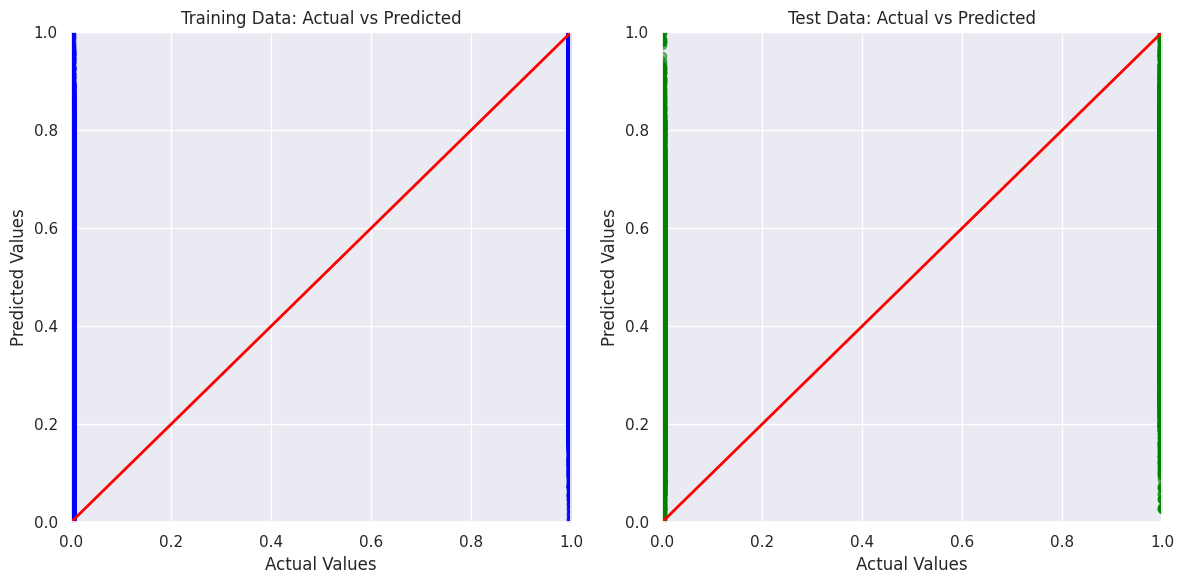

In [ ]:
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)

# Selecting features
X = df[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol']]
y = df['cardio']  # Target variable

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transforming features
X_poly_train = poly.fit_transform(X_train)  # Fit and transform training data
X_poly_test = poly.transform(X_test)  # Transform test data

# Fitting Linear Regression Model with Polynomial Features
model = LinearRegression()
model.fit(X_poly_train, y_train) # Fit using the transformed training data

# Predictions
y_pred_train = model.predict(X_poly_train)  # Use transformed training data
y_pred_test = model.predict(X_poly_test)  # Use transformed test data

# Evaluating the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Polynomial Degree: {degree}")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")

# Plotting predictions vs actual values
plt.figure(figsize=(12, 6))

# Plot for training data
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)  # Diagonal line
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([y_train.min(), y_train.max()])
plt.ylim([y_train.min(), y_train.max()])

# Plot for test data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Diagonal line
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([y_test.min(), y_test.max()])
plt.ylim([y_test.min(), y_test.max()])

plt.tight_layout()
plt.show()

**Inference:**<br>
Overall, the graph suggests that the polynomial regression model of degree 2 might underfit the data. This means that the model is not complex enough to capture the underlying relationship between the features and the target variable. We have tried increasing the degree of the polynomial to see if it improves the model's performance. However, increasing the polynomial degree too much can lead to overfitting.

**Conclusion:**
On trying various combinations of degree=2 and feature columns, we get approximately the same value for MSE on training and testing ie. around 0.20-0.22. r^2 value is comparatively better when degree=2 and only some of the feature columns are taken into account. However, low r^2 values in polynomial regression suggest that the model isn't effectively capturing the variance in the target variable.<br>
Overall, the MSE and r^2 values are remaining almost the same even if we change the degree from 2 to 5. The above graph and the variation of r^2 and MSE values for different degrees clearly indicates underfitting.

**Multiple Linear Regression (MLR)**

It is an extension of simple linear regression that allows us to model the relationship between one dependent variable and multiple independent variables. MLR helps identify the influence of each independent variable on the dependent variable, which can be valuable for understanding the key drivers of the outcome.

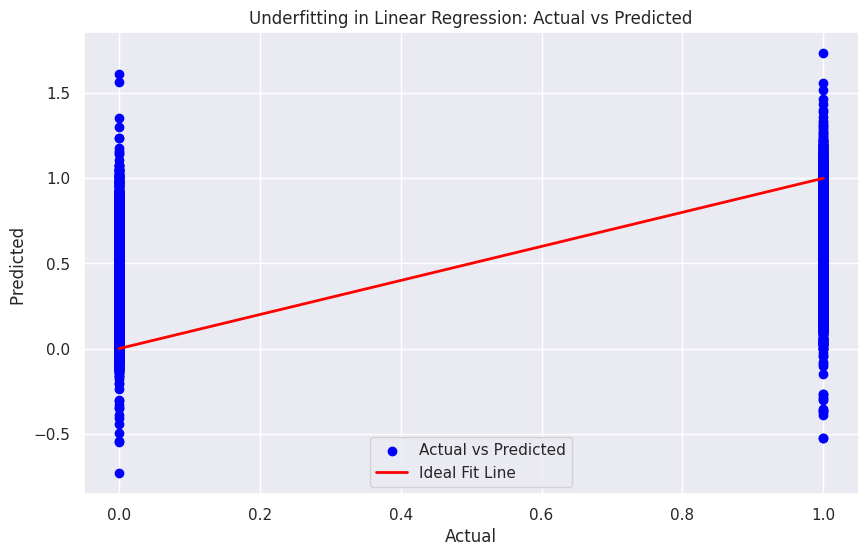

Mean Squared Error Train (Multiple Linear Regression):0.19544523413046672
Mean Squared Error Test (Multiple Linear Regression): 0.19445584903988994
r2 train score is 0.21801414958678345
r2 test score is 0.22212981859480385
Train Bias: 0.0, Variance: 0.05448925512811718
Test Bias: -0.004581842830304883, Variance: 0.05389585499897635


In [ ]:
#Scaling using dataset without outliers(weight,ap_lo,ap_hi)
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop('cardio', axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)
X_train.shape, X_test.shape
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#Applying MLR
reg = LinearRegression()
reg.fit(X_train_scaled,y_train)
LinearRegression()
y_train_pred = reg.predict(X_train_scaled)
y_test_pred = reg.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color='red', linewidth=2, label='Ideal Fit Line')
plt.title('Underfitting in Linear Regression: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted ')
plt.legend()
plt.show()

def calculate_bias_variance(y_true, y_pred):
  bias = np.mean(y_pred) - np.mean(y_true)
  variance = np.var(y_pred)
  return bias, variance

# Calculate Mean Squared Error (MSE) for both the training and testing sets
mse_train= mean_squared_error(y_train, y_train_pred)
mse_test= mean_squared_error(y_test, y_test_pred)
r2_train= r2_score(y_train, y_train_pred)
r2_test= r2_score(y_test, y_test_pred)
print(f'Mean Squared Error Train (Multiple Linear Regression):{mse_train}')
print(f'Mean Squared Error Test (Multiple Linear Regression): {mse_test}')
print('r2 train score is', r2_train)
print('r2 test score is', r2_test)
bias_train, variance_train = calculate_bias_variance(y_train,y_train_pred)
bias_test, variance_test = calculate_bias_variance(y_test,y_test_pred)
print(f"Train Bias: {bias_train}, Variance: {variance_train}")
print(f"Test Bias: {bias_test}, Variance: {variance_test}")


Based on the  metrics,

Mean Squared Error (MSE):Both training and test MSE values are quite close, indicating that the model is not overfitting, as it's not performing significantly worse on unseen data.

R-squared (R²) Scores:The R² values are relatively low, which suggests that the model is not capturing much of the variance in the data. This indicate underfitting, where the model is too simplistic to capture the relationships in the data effectively.

Bias and Variance:These bias and variance values are low, showing that the model's predictions are relatively stable but not very accurate. This is consistent with underfitting, as the model does not have enough complexity to capture the underlying patterns.

In conclusion, this model appears to be underfitting the data due to the low R² values and balanced error metrics. To improve performance, consider adding more features, using a more complex model, or trying polynomial features to capture non-linear relationships.

**Lasso Penalty Regularization:**

In logistic regression, the Lasso penalty is a type of regularization called L1 regularization. It adds a penalty term based on the absolute values of the model's coefficients to the loss function, making it effective for feature selection. This penalty encourages some coefficients to become exactly zero, effectively removing some features and helping the model generalize better by reducing complexity. This method is thus used to reduce overfitting by removing any unnecessary parameters that contribute to noise in the system that cause overfitting, thus increasing accuracy

In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np
# Applying PCA on Standard Scaled data
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop('cardio', axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)
# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
np.round(X_train.describe(), 1)
np.round(X_train_scaled.describe(), 1)
lr_test_scaled = LogisticRegression()
lr_test_scaled_lasso = LogisticRegression(penalty='l1', solver='liblinear', C = 0.45)

lr_test_scaled.fit(X_train_scaled, y_train)
lr_test_scaled_lasso.fit(X_train_scaled, y_train)

#making predictions
y_pred_scaled = lr_test_scaled.predict(X_test_scaled)
y_pred_scaled_lasso  = lr_test_scaled_lasso.predict(X_test_scaled)
y_pred_train_scaled = lr_test_scaled.predict(X_train_scaled)
y_pred_train_scaled_lasso = lr_test_scaled_lasso.predict(X_train_scaled)

# Evaluating the accuracy of both models
print("Accuracy Standard Scaled without penalty:",accuracy_score(y_test, y_pred_scaled))
print("Accuracy Standard Scaled with Lasso penalty:",accuracy_score(y_test, y_pred_scaled_lasso))

y_train_pred_scaled = lr_test_scaled.predict(X_train_scaled)
y_train_pred_scaled_lasso = lr_test_scaled_lasso.predict(X_train_scaled)

# Calculate Mean Squared Error (MSE) on test data
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
mse_scaled_lasso = mean_squared_error(y_test, y_pred_scaled_lasso)

# Bias (mean difference between predictions and actual values)
bias_squared_scaled = np.mean((y_test - y_pred_scaled))
bias_squared_scaled_lasso = np.mean((y_test - y_pred_scaled_lasso))

# Variance (how much predictions vary for the same input data)
variance_scaled = np.var(y_train_pred_scaled)
variance_scaled_lasso = np.var(y_train_pred_scaled_lasso)

y_train_pred_scaled = lr_test_scaled.predict(X_train_scaled)
y_train_pred_scaled_lasso = lr_test_scaled_lasso.predict(X_train_scaled)

# Calculate Mean Squared Error (MSE) on train data
mse_train_scaled = mean_squared_error(y_train, y_train_pred_scaled)
mse_train_scaled_lasso = mean_squared_error(y_train, y_train_pred_scaled_lasso)

# Bias (mean difference between predictions and actual values)
bias_squared_train_scaled = np.mean((y_train - y_train_pred_scaled))
bias_squared_train_scaled_lasso = np.mean((y_train - y_train_pred_scaled_lasso))

# Variance (how much predictions vary for the same input data)
variance_train_scaled = np.var(y_train_pred_scaled)
variance_train_scaled_lasso = np.var(y_train_pred_scaled_lasso)

# Print the results
print("\nTrain data - Standard Scaled without penalty:")
print(f"Mean Squared Error: {mse_train_scaled}")
print(f"Bias: {bias_squared_train_scaled}")
print(f"Variance: {variance_train_scaled}\n")

# Print the results
print("Standard Scaled with penalty:")
print(f"Mean Squared Error: {mse_train_scaled_lasso}")
print(f"Bias: {bias_squared_train_scaled_lasso}")
print(f"Variance: {variance_train_scaled_lasso}\n")


print("Test data - Standard Scaled without Lasso penalty:")
print(f"Mean Squared Error: {mse_scaled}")
print(f"Bias: {bias_squared_scaled}")
print(f"Variance: {variance_scaled}\n")

print("Standard Scaled with Lasso penalty:")
print(f"Mean Squared Error: {mse_scaled_lasso}")
print(f"Bias: {bias_squared_scaled_lasso}")
print(f"Variance: {variance_scaled_lasso}")

predictions_binary = (y_pred_scaled_lasso > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy Standard Scaled without penalty: 0.7254170324846356
Accuracy Standard Scaled with Lasso penalty: 0.7255633596722271

Train data - Standard Scaled without penalty:
Mean Squared Error: 0.2740941266850798
Bias: 0.04969728009365111
Variance: 0.24666018290060016

Standard Scaled with penalty:
Mean Squared Error: 0.27402096175303176
Bias: 0.04958753269557901
Variance: 0.2466728557129509

Test data - Standard Scaled without Lasso penalty:
Mean Squared Error: 0.2745829675153644
Bias: 0.05684811237928007
Variance: 0.24666018290060016

Standard Scaled with Lasso penalty:
Mean Squared Error: 0.2744366403277729
Bias: 0.05684811237928007
Variance: 0.2466728557129509

Accuracy: 0.7256
Precision: 0.7523
Recall: 0.6661
F1 Score: 0.7066
Confusion Matrix:
[[5400 1487]
 [2264 4517]]


**Inference:**

Lasso Penalty with a strength of 0.45 was found to be the best for increasing accuracy. Even then, the accuracy was only found to be increased by 0.00015 which is negligible.

Another observation to note is that the Mean Squared Error and the Bias of the
of both training and testing data with and without lasso penalty are very similiar, suggesting that the model is aldready well balanced

**Result:**

L1 Penalty Regularization applicable to the model however it only increases accuracy by a negligible amount.

L2

In [35]:

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
np.round(X_train.describe(), 1)
np.round(X_train_scaled.describe(), 1)
lr_test_scaled = LogisticRegression()
lr_test_scaled_ridge = LogisticRegression(penalty='l2', solver='liblinear', C = 0.15)

lr_test_scaled.fit(X_train_scaled, y_train)
lr_test_scaled_ridge.fit(X_train_scaled, y_train)

#making predictions
y_pred_scaled = lr_test_scaled.predict(X_test_scaled)
y_pred_scaled_ridge  = lr_test_scaled_ridge.predict(X_test_scaled)
y_pred_train_scaled = lr_test_scaled.predict(X_train_scaled)
y_pred_train_scaled_ridge = lr_test_scaled_ridge.predict(X_train_scaled)

# Evaluating the accuracy of both models
print("Accuracy Standard Scaled without penalty:",accuracy_score(y_test, y_pred_scaled))
print("Accuracy Standard Scaled with ridgepenalty:",accuracy_score(y_test, y_pred_scaled_ridge))

y_train_pred_scaled = lr_test_scaled.predict(X_train_scaled)
y_train_pred_scaled_ridge = lr_test_scaled_ridge.predict(X_train_scaled)

# Calculate Mean Squared Error (MSE) on test data
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
mse_scaled_ridge = mean_squared_error(y_test, y_pred_scaled_ridge)

# Bias (mean difference between predictions and actual values)
bias_squared_scaled = np.mean((y_test - y_pred_scaled))
bias_squared_scaled_ridge= np.mean((y_test - y_pred_scaled_ridge))

# Variance (how much predictions vary for the same input data)
variance_scaled = np.var(y_train_pred_scaled)
variance_scaled_ridge= np.var(y_train_pred_scaled_ridge)

y_train_pred_scaled = lr_test_scaled.predict(X_train_scaled)
y_train_pred_scaled_ridge= lr_test_scaled_ridge.predict(X_train_scaled)

# Calculate Mean Squared Error (MSE) on train data
mse_train_scaled = mean_squared_error(y_train, y_train_pred_scaled)
mse_train_scaled_ridge = mean_squared_error(y_train, y_train_pred_scaled_ridge)

# Bias (mean difference between predictions and actual values)
bias_squared_train_scaled = np.mean((y_train - y_train_pred_scaled))
bias_squared_train_scaled_ridge = np.mean((y_train - y_train_pred_scaled_ridge))

# Variance (how much predictions vary for the same input data)
variance_train_scaled = np.var(y_train_pred_scaled)
variance_train_scaled_ridge = np.var(y_train_pred_scaled_ridge)

# Print the results
print("\nTrain data - Standard Scaled without penalty:")
print(f"Mean Squared Error: {mse_train_scaled}")
print(f"Bias: {bias_squared_train_scaled}")
print(f"Variance: {variance_train_scaled}\n")

# Print the results
print("Standard Scaled with penalty:")
print(f"Mean Squared Error: {mse_train_scaled_ridge}")
print(f"Bias: {bias_squared_train_scaled_ridge}")
print(f"Variance: {variance_train_scaled_ridge}\n")


print("Test data - Standard Scaled without ridge penalty:")
print(f"Mean Squared Error: {mse_scaled}")
print(f"Bias: {bias_squared_scaled}")
print(f"Variance: {variance_scaled}\n")

print("Standard Scaled with ridge penalty:")
print(f"Mean Squared Error: {mse_scaled_ridge}")
print(f"Bias: {bias_squared_scaled_ridge}")
print(f"Variance: {variance_scaled_ridge}")

predictions_binary = (y_pred_scaled_ridge > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy Standard Scaled without penalty: 0.7254170324846356
Accuracy Standard Scaled with ridgepenalty: 0.7252707052970442

Train data - Standard Scaled without penalty:
Mean Squared Error: 0.2740941266850798
Bias: 0.04969728009365111
Variance: 0.24666018290060016

Standard Scaled with penalty:
Mean Squared Error: 0.2740941266850798
Bias: 0.04958753269557901
Variance: 0.2466728557129509

Test data - Standard Scaled without ridge penalty:
Mean Squared Error: 0.2745829675153644
Bias: 0.05684811237928007
Variance: 0.24666018290060016

Standard Scaled with ridge penalty:
Mean Squared Error: 0.2747292947029558
Bias: 0.05655545800409716
Variance: 0.2466728557129509

Accuracy: 0.7253
Precision: 0.7518
Recall: 0.6661
F1 Score: 0.7064
Confusion Matrix:
[[5396 1491]
 [2264 4517]]


The 'C' parameter is a hyperparameter that controls the strength of regularization in logistic regression. It's inversely proportional to the regularization strength:<br>

High C: Less regularization, model is more prone to overfitting.<br>
Low C: More regularization, model is more robust to overfitting but might underfit.<br>

When you decrease the value of 'C', you're increasing the regularization strength. This leads to:<br>

Reduced Model Complexity: The model becomes simpler, with smaller coefficient values.<br>
Improved Generalization: The model is less likely to overfit the training data, leading to better performance on unseen data.<br>
Different Decision Boundaries: The decision boundary, which separates the classes, becomes less complex. It might become linear or have fewer curves.<br>
Impact on Model Performance:<br>

Lower Training Accuracy: A lower 'C' might lead to lower accuracy on the training set as the model becomes less flexible.
Higher Test Accuracy: However, a lower 'C' often leads to higher accuracy on the test set, especially if the training data is noisy or the model is prone to overfitting.

In [38]:
# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
np.round(X_train.describe(), 1)
np.round(X_train_scaled.describe(), 1)
lr_test_scaled = LogisticRegression()
lr_test_scaled_ridge = LogisticRegression(penalty='l2', solver='liblinear', C = 0.001)

lr_test_scaled.fit(X_train_scaled, y_train)
lr_test_scaled_ridge.fit(X_train_scaled, y_train)

#making predictions
y_pred_scaled = lr_test_scaled.predict(X_test_scaled)
y_pred_scaled_ridge  = lr_test_scaled_ridge.predict(X_test_scaled)
y_pred_train_scaled = lr_test_scaled.predict(X_train_scaled)
y_pred_train_scaled_ridge = lr_test_scaled_ridge.predict(X_train_scaled)

# Evaluating the accuracy of both models
print("Accuracy Standard Scaled without penalty:",accuracy_score(y_test, y_pred_scaled))
print("Accuracy Standard Scaled with ridgepenalty:",accuracy_score(y_test, y_pred_scaled_ridge))

y_train_pred_scaled = lr_test_scaled.predict(X_train_scaled)
y_train_pred_scaled_ridge = lr_test_scaled_ridge.predict(X_train_scaled)

# Calculate Mean Squared Error (MSE) on test data
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
mse_scaled_ridge = mean_squared_error(y_test, y_pred_scaled_ridge)

# Bias (mean difference between predictions and actual values)
bias_squared_scaled = np.mean((y_test - y_pred_scaled))
bias_squared_scaled_ridge= np.mean((y_test - y_pred_scaled_ridge))

# Variance (how much predictions vary for the same input data)
variance_scaled = np.var(y_train_pred_scaled)
variance_scaled_ridge= np.var(y_train_pred_scaled_ridge)

y_train_pred_scaled = lr_test_scaled.predict(X_train_scaled)
y_train_pred_scaled_ridge= lr_test_scaled_ridge.predict(X_train_scaled)

# Calculate Mean Squared Error (MSE) on train data
mse_train_scaled = mean_squared_error(y_train, y_train_pred_scaled)
mse_train_scaled_ridge = mean_squared_error(y_train, y_train_pred_scaled_ridge)

# Bias (mean difference between predictions and actual values)
bias_squared_train_scaled = np.mean((y_train - y_train_pred_scaled))
bias_squared_train_scaled_ridge = np.mean((y_train - y_train_pred_scaled_ridge))

# Variance (how much predictions vary for the same input data)
variance_train_scaled = np.var(y_train_pred_scaled)
variance_train_scaled_ridge = np.var(y_train_pred_scaled_ridge)

# Print the results
print("\nTrain data - Standard Scaled without penalty:")
print(f"Mean Squared Error: {mse_train_scaled}")
print(f"Bias: {bias_squared_train_scaled}")
print(f"Variance: {variance_train_scaled}\n")

# Print the results
print("Standard Scaled with penalty:")
print(f"Mean Squared Error: {mse_train_scaled_ridge}")
print(f"Bias: {bias_squared_train_scaled_ridge}")
print(f"Variance: {variance_train_scaled_ridge}\n")


print("Test data - Standard Scaled without ridge penalty:")
print(f"Mean Squared Error: {mse_scaled}")
print(f"Bias: {bias_squared_scaled}")
print(f"Variance: {variance_scaled}\n")

print("Standard Scaled with ridge penalty:")
print(f"Mean Squared Error: {mse_scaled_ridge}")
print(f"Bias: {bias_squared_scaled_ridge}")
print(f"Variance: {variance_scaled_ridge}")

predictions_binary = (y_pred_scaled_ridge > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy Standard Scaled without penalty: 0.7254170324846356
Accuracy Standard Scaled with ridgepenalty: 0.7251975417032485

Train data - Standard Scaled without penalty:
Mean Squared Error: 0.2740941266850798
Bias: 0.04969728009365111
Variance: 0.24666018290060016

Standard Scaled with penalty:
Mean Squared Error: 0.2748623584715846
Bias: 0.04468548224835836
Variance: 0.2472143399120832

Test data - Standard Scaled without ridge penalty:
Mean Squared Error: 0.2745829675153644
Bias: 0.05684811237928007
Variance: 0.24666018290060016

Standard Scaled with ridge penalty:
Mean Squared Error: 0.27480245829675154
Bias: 0.05194615159496634
Variance: 0.2472143399120832

Accuracy: 0.7252
Precision: 0.7491
Recall: 0.6707
F1 Score: 0.7077
Confusion Matrix:
[[5364 1523]
 [2233 4548]]


**Inferences:**

Even after changing the hyperparameter 'c' we are not getting the expected results<br>
Ridge penalty: The ridge penalty has not significantly improved the model's performance in this case. It very marginally improves recall at the cost of precision

**Elastic Net**

It is a regularized regression technique that combines Lasso (L1) and Ridge (L2) penalties. It’s particularly useful for datasets with many correlated features or multicollinearity.By combining both L1 and L2 penalties, Elastic Net gives a balanced approach to shrinkage, making it useful for high-dimensional datasets with a mixture of strong and weak predictors.

Elastic Net reduces overfitting by regularizing the coefficients, especially useful if the dataset is large or has many features.By tuning the alpha (overall regularization strength) and the ratio of L1 and L2 penalties, Elastic Net can often outperform Linear or Lasso Regression alone, as it balances coefficient shrinkage and feature selection.

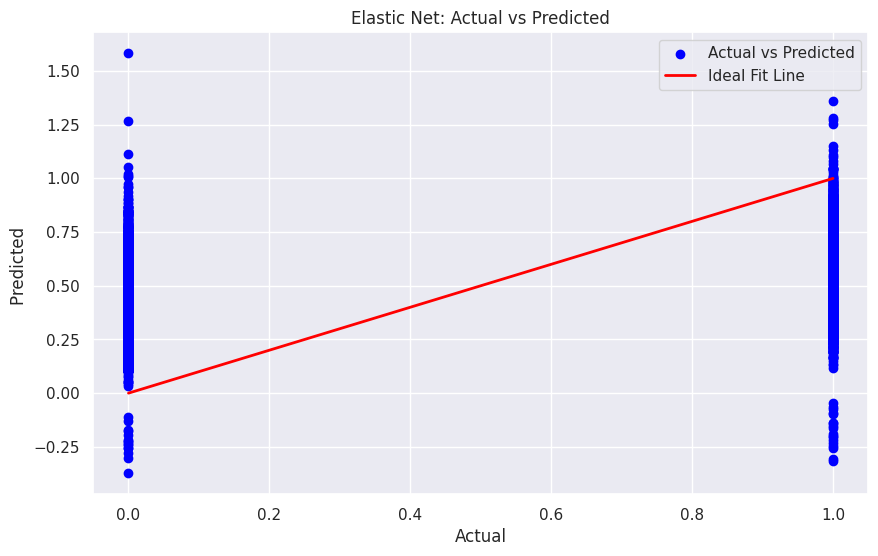

Mean Squared Error Train (Elastic Net):0.2036426053885683
Mean Squared Error Test (Elastic Net): 0.20308832736580132
r2 train score is 0.18521607004834684
r2 test score is 0.18759782835379235
Train Bias: 0.0, Variance: 0.023950033233833594
Test Bias: -0.004661595079374525, Variance: 0.023750625438791268
Accuracy Train (Elastic Net): 0.7229975672660094
Accuracy Test (Elastic Net): 0.7221246707638279

Accuracy: 0.7221
Precision: 0.7650
Recall: 0.6350
F1 Score: 0.6940
Confusion Matrix:
[[5564 1323]
 [2475 4306]]


In [39]:
#Scaling using dataset without outliers(weight,ap_lo,ap_hi)
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop('cardio', axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)
X_train.shape, X_test.shape
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#Applying Elastic Net
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train_scaled, y_train)
# Make predictions
y_train_pred = elastic_net.predict(X_train_scaled)
y_test_pred = elastic_net.predict(X_test_scaled)

#Plot the Elastic Net graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color='red', linewidth=2, label='Ideal Fit Line')
plt.title('Elastic Net: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted ')
plt.legend()
plt.show()

def calculate_bias_variance(y_true, y_pred):
  bias = np.mean(y_pred) - np.mean(y_true)
  variance = np.var(y_pred)
  return bias, variance

# Calculate for both the training and testing sets
mse_train= mean_squared_error(y_train, y_train_pred)
mse_test= mean_squared_error(y_test, y_test_pred)
r2_train= r2_score(y_train, y_train_pred)
r2_test= r2_score(y_test, y_test_pred)
print(f'Mean Squared Error Train (Elastic Net):{mse_train}')
print(f'Mean Squared Error Test (Elastic Net): {mse_test}')
print('r2 train score is', r2_train)
print('r2 test score is', r2_test)
bias_train, variance_train = calculate_bias_variance(y_train,y_train_pred)
bias_test, variance_test = calculate_bias_variance(y_test,y_test_pred)
print(f"Train Bias: {bias_train}, Variance: {variance_train}")
print(f"Test Bias: {bias_test}, Variance: {variance_test}")


# Convert predictions to binary classes (assuming 0.5 as the threshold)
y_train_pred_binary = (y_train_pred >= 0.5).astype(int)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

# Calculate accuracy
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
accuracy_test = accuracy_score(y_test, y_test_pred_binary)
print(f'Accuracy Train (Elastic Net): {accuracy_train}')
print(f'Accuracy Test (Elastic Net): {accuracy_test}')

predictions_binary = y_test_pred_binary

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

With the results we can say the model is performing similarly on both the training and test datasets, with relatively low bias and variance, which is generally a good sign. The accuracy values seem high, suggesting that the model is correctly classifying a significant portion of the data, although it’s worth noting that accuracy is more commonly reported for classification tasks.

So we should lower the alpha and l1_ratio values in Elastic Net which can lead to a more complex model that captures more information from the data, potentially improving performance on training data.Also,lowering these values may decrease bias but can increase variance. Since our model is underfitting, adjusting these parameters can help capture more of the underlying patterns in the data. Based on evaluation metrics, recall is now very low at the benefit of boosting precision

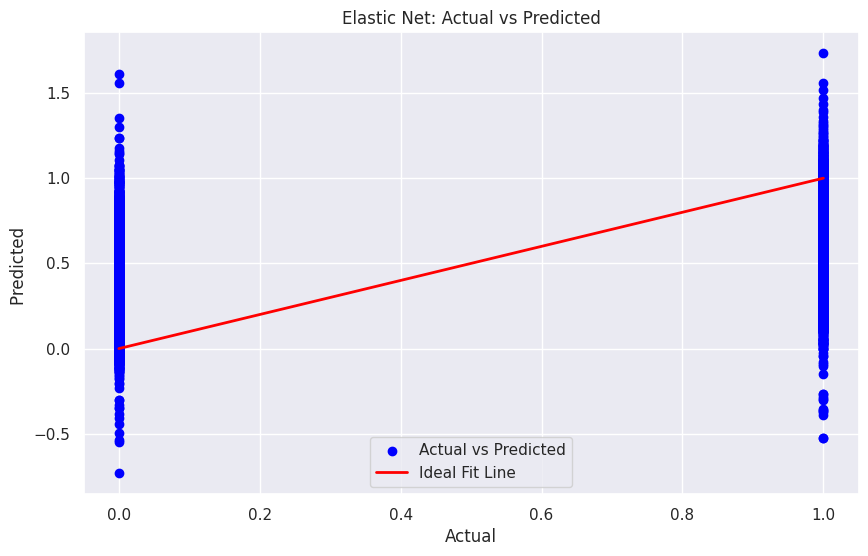

Mean Squared Error Train (Elastic Net):0.19544572620492962
Mean Squared Error Test (Elastic Net): 0.19445618303175652
r2 train score is 0.2180121807730181
r2 test score is 0.2221284825469806
Train Bias: 0.0, Variance: 0.05448230282276208
Test Bias: -0.004583424834178396, Variance: 0.053890399450562655
Accuracy Train (Elastic Net): 0.724753525635163
Accuracy Test (Elastic Net): 0.7241000877963125

Accuracy: 0.7241
Precision: 0.7488
Recall: 0.6679
F1 Score: 0.7061
Confusion Matrix:
[[5368 1519]
 [2252 4529]]


In [41]:
#Scaling using dataset without outliers(weight,ap_lo,ap_hi)
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop('cardio', axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)
X_train.shape, X_test.shape
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#Applying Elastic Net
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.0001, l1_ratio=0.005, random_state=42)
elastic_net.fit(X_train_scaled, y_train)
# Make predictions
y_train_pred = elastic_net.predict(X_train_scaled)
y_test_pred = elastic_net.predict(X_test_scaled)

#Plot the Elastic Net graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color='red', linewidth=2, label='Ideal Fit Line')
plt.title('Elastic Net: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted ')
plt.legend()
plt.show()

def calculate_bias_variance(y_true, y_pred):
  bias = np.mean(y_pred) - np.mean(y_true)
  variance = np.var(y_pred)
  return bias, variance

# Calculate for both the training and testing sets
mse_train= mean_squared_error(y_train, y_train_pred)
mse_test= mean_squared_error(y_test, y_test_pred)
r2_train= r2_score(y_train, y_train_pred)
r2_test= r2_score(y_test, y_test_pred)
print(f'Mean Squared Error Train (Elastic Net):{mse_train}')
print(f'Mean Squared Error Test (Elastic Net): {mse_test}')
print('r2 train score is', r2_train)
print('r2 test score is', r2_test)
bias_train, variance_train = calculate_bias_variance(y_train,y_train_pred)
bias_test, variance_test = calculate_bias_variance(y_test,y_test_pred)
print(f"Train Bias: {bias_train}, Variance: {variance_train}")
print(f"Test Bias: {bias_test}, Variance: {variance_test}")


# Convert predictions to binary classes (assuming 0.5 as the threshold)
y_train_pred_binary = (y_train_pred >= 0.5).astype(int)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

# Calculate accuracy
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
accuracy_test = accuracy_score(y_test, y_test_pred_binary)
print(f'Accuracy Train (Elastic Net): {accuracy_train}')
print(f'Accuracy Test (Elastic Net): {accuracy_test}')

predictions_binary = y_test_pred_binary

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

**Analysis:**

The model appears to be performing well with low MSE values for both training and testing datasets. The close values suggest that the model is generalizing well without significant overfitting.

The R² scores are modest, indicating that there may be room for improvement in capturing more variance in the target variable. You might explore feature engineering or trying other algorithms to enhance performance.

The very low bias combined with low variance suggests a well-balanced model. It captures the underlying patterns in the training data without being overly complex.

It demonstrates good performance metrics overall. While the explained variance is not very high, the low MSE and consistent bias-variance indicate a model that is well-tuned for the data at hand.

**Random Forest Classifier:**

It provides a convenient way to assess feature importance based on how well each feature contributes to decision-making within the model.
By examining feature importance, we can reduce the dimensionality in our dataset by selecting only the most influential features, which can lead to improved model efficiency and interpretability.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
#RFC on  dataset without outliers(weight,ap_lo,ap_hi)
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)
X_train.shape, X_test.shape

rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rfc.feature_importances_})

import plotly.express as px
px.bar(importance_df,x='Importance',y='Feature', orientation='h',title='Importance of each Feature')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
#RFC on Scaling using dataset without outliers(weight,ap_lo,ap_hi)
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)
X_train.shape, X_test.shape
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train_scaled, y_train)
importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rfc.feature_importances_})

import plotly.express as px
px.bar(importance_df,x='Importance',y='Feature', orientation='h',title='Importance of each Feature')

From above observation v could see that RFC is not sensitive to feature scaling. Outlier removal enhance the robustness of other models but is less critical for RFC.

In [ ]:
# Calculate model performance
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.7087

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      6887
           1       0.71      0.69      0.70      6781

    accuracy                           0.71     13668
   macro avg       0.71      0.71      0.71     13668
weighted avg       0.71      0.71      0.71     13668



**Analysis:**

The most important features according to RFC are:


*  BMI is the top predictor due to its association with cardiovascular health issues like hypertension, diabetes, and metabolic syndrome.
*   Age is another critical feature, as it is naturally linked to the risk of cardiovascular issues due to cumulative health factors.
*  Cholesterol and  Blood Pressure have some predictive power but contribute less compared to the top predictors.

   index  id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0      0   0   50       2     168    62.0    110     80            1     1   
1      1   1   55       1     156    85.0    140     90            3     1   
2      2   2   51       1     165    64.0    130     70            3     1   
3      3   3   48       2     169    82.0    150    100            1     1   
4      4   4   47       1     156    56.0    100     60            1     1   

   smoke  alco  active  cardio        BMI  Hypertension  age_years age_group  
0      0     0       1       0  21.967120             2         50     40-50  
1      0     0       1       1  34.927679             3         55     50-60  
2      0     0       0       1  23.507805             2         51     50-60  
3      0     0       1       1  28.710479             3         48     40-50  
4      0     0       0       0  23.011177             0         47     40-50  


<ipython-input-184-60b5777b8412>:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-184-60b5777b8412>:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-184-60b5777b8412>:30: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-184-60b5777b8412>:30: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

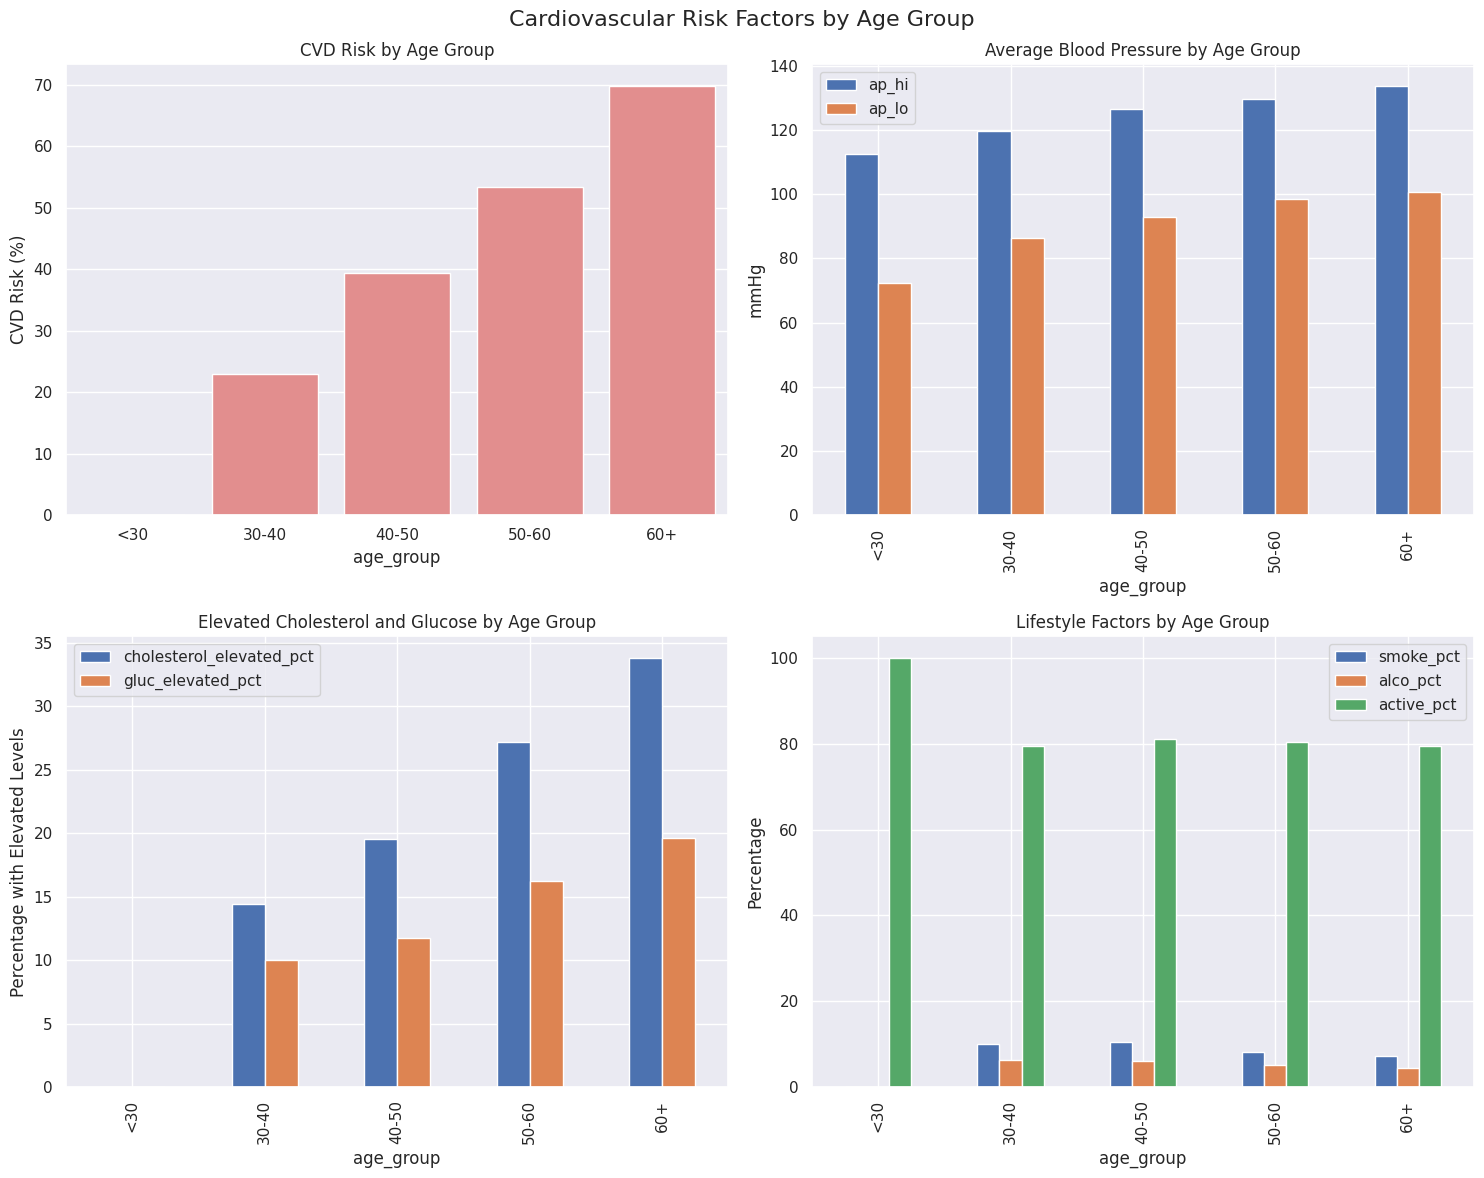


Detailed Risk Factor Analysis by Age Group:
            ap_hi   ap_lo  weight  cholesterol_elevated_pct  \
age_group                                                     
<30        112.50   72.50   67.25                      0.00   
30-40      119.74   86.30   71.63                     14.42   
40-50      126.43   93.04   73.52                     19.51   
50-60      129.73   98.66   74.60                     27.18   
60+        133.81  100.62   75.14                     33.80   

           gluc_elevated_pct  smoke_pct  alco_pct  active_pct  cvd_risk_pct  
age_group                                                                    
<30                     0.00       0.00      0.00      100.00          0.00  
30-40                   9.99      10.11      6.26       79.52         22.91  
40-50                  11.75      10.44      6.15       81.09         39.34  
50-60                  16.20       8.13      5.10       80.31         53.41  
60+                    19.64       7.33      

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert age from days to years and create age groups
print(df.head(5))
df['age_years'] = df['age']
df['age_group'] = pd.cut(df['age_years'],
                        bins=[0, 30, 40, 50, 60, 100],
                        labels=['<30', '30-40', '40-50', '50-60', '60+'])

def analyze_age_groups(data):
    # Calculate risk factors by age group
    age_analysis = pd.DataFrame()

    # Calculate percentages of cardiovascular disease by age group
    cvd_by_age = data.groupby('age_group')['cardio'].mean() * 100

    # Calculate mean values for continuous variables
    continuous_vars = ['ap_hi', 'ap_lo', 'weight']
    means = data.groupby('age_group')[continuous_vars].mean()

    # Calculate percentages for categorical variables
    categorical_vars = ['cholesterol', 'gluc', 'smoke', 'alco', 'active']
    for var in categorical_vars:
        if var in ['cholesterol', 'gluc']:
            # For multilevel variables (1,2,3)
            high_risk = data[var] > 1
            risk_by_age = data.groupby('age_group')[var].apply(
                lambda x: (x > 1).mean() * 100
            )
            means[f'{var}_elevated_pct'] = risk_by_age
        else:
            # For binary variables
            risk_by_age = data.groupby('age_group')[var].mean() * 100
            means[f'{var}_pct'] = risk_by_age

    # Add CVD percentage
    means['cvd_risk_pct'] = cvd_by_age

    return means

# Generate analysis
age_group_analysis = analyze_age_groups(df)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cardiovascular Risk Factors by Age Group', fontsize=16)

# Plot 1: CVD Risk Percentage
sns.barplot(x=age_group_analysis.index, y=age_group_analysis['cvd_risk_pct'],
           ax=axes[0,0], color='lightcoral')
axes[0,0].set_title('CVD Risk by Age Group')
axes[0,0].set_ylabel('CVD Risk (%)')

# Plot 2: Blood Pressure
age_group_analysis[['ap_hi', 'ap_lo']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Average Blood Pressure by Age Group')
axes[0,1].set_ylabel('mmHg')

# Plot 3: Cholesterol and Glucose
age_group_analysis[['cholesterol_elevated_pct', 'gluc_elevated_pct']].plot(
    kind='bar', ax=axes[1,0])
axes[1,0].set_title('Elevated Cholesterol and Glucose by Age Group')
axes[1,0].set_ylabel('Percentage with Elevated Levels')

# Plot 4: Lifestyle Factors
lifestyle_cols = ['smoke_pct', 'alco_pct', 'active_pct']
age_group_analysis[lifestyle_cols].plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Lifestyle Factors by Age Group')
axes[1,1].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Risk Factor Analysis by Age Group:")
print(age_group_analysis.round(2))

# Calculate risk factor correlations with age
correlations = df[['age_years', 'ap_hi', 'ap_lo', 'weight',
                   'cholesterol', 'gluc', 'cardio']].corr()['age_years']
print("\nCorrelations with Age:")
print(correlations.round(3))
df.drop('age_group',axis=1,inplace=True);

**Inference:**
These are the graphs we obtained after trying various scaling and outlier removal methods. As we can see, the graphs have remained almost the same even after data cleaning. Summarizing them together for ease of visualization.

Tensorflow+PCA

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Set random seeds for reproducibility
np.random.seed(42)  # Set seed for NumPy
tf.random.set_seed(42)  # Set seed for TensorFlow

# Load your dataset
y = df['cardio']  # Assuming 'cardio' is your target variable
X = df.drop(columns=['cardio'])  # Drop the target variable to get features

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Performing PCA
pca = PCA(n_components=5)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

# Define a simple Neural Network model using TensorFlow/Keras
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=input_dim))  # First hidden layer
    model.add(Dense(5, activation='relu'))                        # Second hidden layer
    model.add(Dense(1, activation='sigmoid'))                     # Output layer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model on PCA data
model_pca = create_model(input_dim=X_train_scaled_pca.shape[1])
model_pca.fit(X_train_scaled_pca, y_train, epochs=50, batch_size=32, verbose=1)

history_pca = model_pca.fit(X_train_scaled_pca, y_train, epochs=50, batch_size=32, verbose=0)


# Evaluate the model on the test set
loss, accuracy = model_pca.evaluate(X_test_scaled_pca, y_test, verbose=0)
print(f"TensorFlow Model Accuracy on PCA-transformed Test Set: {accuracy:.4f}")

# Making predictions
y_pred_pca = (model_pca.predict(X_test_scaled_pca) > 0.5).astype("int32")
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy from Predictions on PCA Data: {accuracy_pca:.4f}")

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5781 - loss: 0.6801
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6385 - loss: 0.6400
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6405 - loss: 0.6375
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6413 - loss: 0.6367
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6398 - loss: 0.6362
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6402 - loss: 0.6360
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6415 - loss: 0.6357
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6416 - loss: 0.6356
Epoch 9/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6413 - loss: 0.6355
Epoch 10/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6412 - loss: 0.6354
Epoch 11/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6412 - loss: 0.6354
Epoch 12/50
1750/1750 ━━━━━━━━

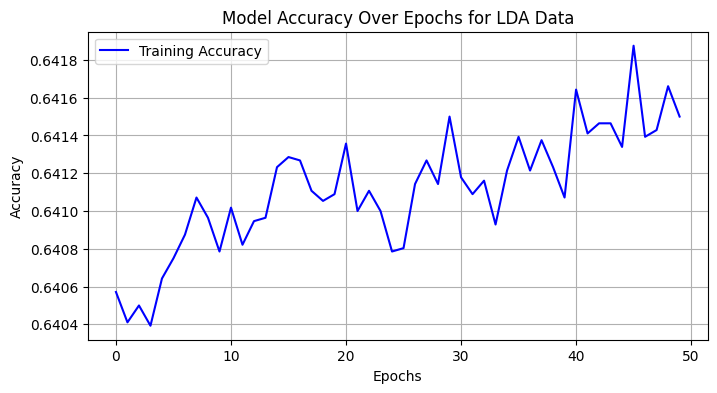

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history_pca.history['accuracy'], label='Training Accuracy', color='blue')
plt.title('Model Accuracy Over Epochs for LDA Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

**Inference:**<br>
The model achieved an accuracy of 68.49% on the PCA-transformed test set. This accuracy is quite competitive, suggesting that PCA has effectively reduced the dimensionality while retaining important information for classification.<br>

**Training Observations:**<br>
The model starts with an accuracy of 64.40% in the first epoch and increases to 69.04% by epoch 13, indicating steady learning and improvement. The gradual rise in accuracy suggests that the model is learning effectively from the PCA-transformed data.<br>

**Loss Values:**<br>
The loss values are decreasing over the epochs, which is a positive sign, indicating that the model is improving in its ability to minimize errors as training progresses. The steady decrease in loss may also reflect that the PCA transformation is making the features more interpretable for the model.

Tensorflow+LDA

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD  # Import TruncatedSVD
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load your dataset
# Assuming df is your DataFrame and 'cardio' is your target variable
y = df['cardio']  # Target variable
X = df.drop(columns=['cardio'])  # Feature variables

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying LDA
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train_scaled, y_train)

# Transform the training and test data
X_train_lda = lda.transform(X_train_scaled)
X_test_lda = lda.transform(X_test_scaled)

# Fit Logistic Regression on LDA transformed data for finding the accuracy
lr_lda = LogisticRegression()
lr_lda.fit(X_train_lda, y_train)

# Making predictions with the LDA model
y_pred_lda = lr_lda.predict(X_test_lda)

# Calculating accuracy for LDA model
lda_accuracy = accuracy_score(y_test, y_pred_lda)

# Print LDA accuracy
print("LDA Model Accuracy:", lda_accuracy)
# Now, create a TensorFlow model using the LDA transformed data
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=input_dim))  # First hidden layer
    model.add(Dense(5, activation='relu'))                        # Second hidden layer
    model.add(Dense(1, activation='sigmoid'))                     # Output layer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model on LDA transformed data
model_lda = create_model(input_dim=X_train_lda.shape[1])
model_lda.fit(X_train_lda, y_train, epochs=50, batch_size=32, verbose=1)
history_lda = model_lda.fit(X_train_lda, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model_lda.evaluate(X_test_lda, y_test, verbose=0)
print(f"TensorFlow Model Accuracy on LDA-transformed Test Set: {accuracy:.4f}")

# Making predictions
y_pred_lda_tf = (model_lda.predict(X_test_lda) > 0.5).astype("int32")
accuracy_lda_tf = accuracy_score(y_test, y_pred_lda_tf)
print(f"Accuracy from Predictions on LDA Data using TensorFlow: {accuracy_lda_tf:.4f}")


LDA Model Accuracy: 0.6967857142857142


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6837 - loss: 0.6021
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6982 - loss: 0.5877
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6981 - loss: 0.5875
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6979 - loss: 0.5874
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6976 - loss: 0.5872
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6975 - loss: 0.5871
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6974 - loss: 0.5871
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6976 - loss: 0.5870
Epoch 9/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6976 - loss: 0.5869
Epoch 10/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6977 - loss: 0.5869
Epoch 11/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6977 - loss: 0.5868
Epoch 12/50
1750/1750 ━━━━━━━━

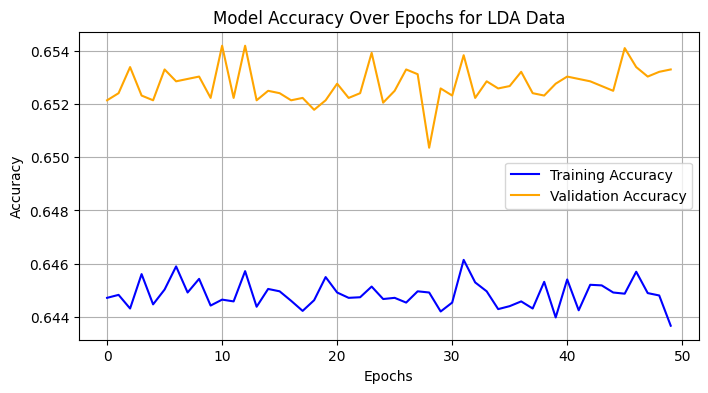

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history_lda.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_lda.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs for LDA Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

**Inference:**<br>
The accuracy of the LDA model on the test set is approximately 65.48%. This indicates that the LDA transformation was somewhat effective in separating the classes based on the features provided.<br>
While LDA can be useful, it may not be the best method for feature transformation for our dataset compared to other methods.<br>

**Training Observations:**<br>
The initial accuracy of 63.48% and its gradual increase over epochs show that the model is learning from the data. However, the improvements are relatively modest, indicating that the learning process is slow and may be reaching a plateau.<br>

**Loss Values:**<br>
The loss values appear to stabilize, suggesting that the model may not have enough capacity to significantly improve on the current performance. This could imply that the architecture is not complex enough to capture all the nuances in the data.

Tensorflow+SVD

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load your dataset
# Assuming df is already defined and contains your dataset
y = df['cardio']  # Assuming 'cardio' is your target variable
X = df.drop(columns=['cardio'])  # Drop the target variable to get features

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVD for dimensionality reduction
svd = TruncatedSVD(n_components=5)
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd = svd.transform(X_test_scaled)

# Train Logistic Regression on scaled data
model_scaled = LogisticRegression()
model_scaled.fit(X_train_scaled, y_train)

# Train Logistic Regression on SVD data
model_svd = LogisticRegression()
model_svd.fit(X_train_svd, y_train)

# Evaluate the accuracy on both datasets
print("Accuracy on scaled dataset:", model_scaled.score(X_test_scaled, y_test))
print("Accuracy on SVD dataset:", model_svd.score(X_test_svd, y_test))

# Define a simple Neural Network model using TensorFlow/Keras for SVD data
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=input_dim))  # First hidden layer
    model.add(Dense(5, activation='relu'))                        # Second hidden layer
    model.add(Dense(1, activation='sigmoid'))                     # Output layer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model on SVD data
model_svd_tf = create_model(input_dim=X_train_svd.shape[1])
model_svd_tf.fit(X_train_svd, y_train, epochs=50, batch_size=32, verbose=1)

# Train the model and store history
history_svd_tf = model_svd_tf.fit(X_train_svd, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)
# Evaluate the model on the test set
loss, accuracy = model_svd_tf.evaluate(X_test_svd, y_test, verbose=0)
print(f"TensorFlow Model Accuracy on SVD-transformed Test Set: {accuracy:.4f}")

# Making predictions
y_pred_svd = (model_svd_tf.predict(X_test_svd) > 0.5).astype("int32")
accuracy_svd = accuracy_score(y_test, y_pred_svd)
print(f"Accuracy from Predictions on SVD Data: {accuracy_svd:.4f}")


Accuracy on scaled dataset: 0.7224285714285714
Accuracy on SVD dataset: 0.6303571428571428
Epoch 1/50


c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5828 - loss: 0.6779
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6389 - loss: 0.6380
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6378 - loss: 0.6369
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6376 - loss: 0.6377
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6413 - loss: 0.6352
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6408 - loss: 0.6355
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6379 - loss: 0.6359
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6386 - loss: 0.6361
Epoch 9/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6384 - loss: 0.6365
Epoch 10/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6385 - loss: 0.6350
Epoch 11/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6394 - loss: 0.6358
Epoch 12/50
1750/1750 ━━━━━━━━━━━━━━━━━━━

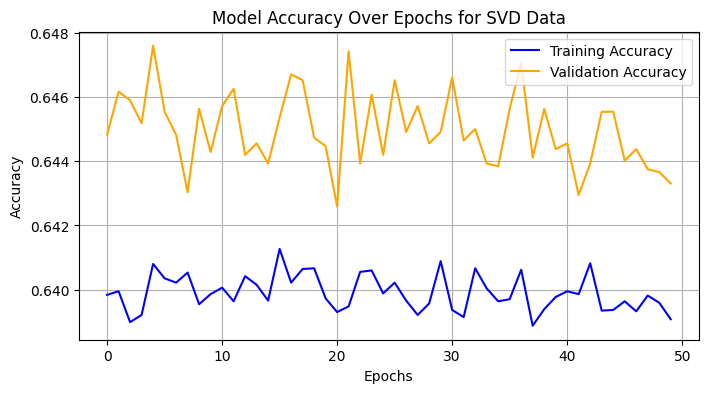

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history_svd_tf.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_svd_tf.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs for SVD Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

**Inference:**<br>
The accuracy of the TensorFlow model on the SVD-transformed test set is 68.38%.<br>
This performance is slightly better than the Logistic Regression model on the SVD data (67.25%), indicating that the neural network is able to capture some additional patterns or relationships in the data through its architecture.

**Training Process:**<br>
The neural network achieved an accuracy of around 64.79% in the first epoch and gradually improved to 68.38% by the end of training. This shows that the model was learning from the data, but the accuracy plateaued rather than continuing to rise significantly.<br>

**Loss Values:**<br>
The loss values fluctuate around a certain point, indicating that the model is learning but may not be making significant improvements in accuracy as the epochs progress.


**Conclusion:**<br>
The use of PCA (Principal Component Analysis) for dimensionality reduction has led to a competitive model performance, achieving an accuracy of 68.49% on the PCA-transformed test set. This accuracy is higher than the results from models using LDA (65.48%) and SVD (67.25%), indicating that PCA effectively retains significant variance and provides a useful representation for classification tasks.

Tensorflow+StandardScaled

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Preprocessing
# Assuming 'target' is the column indicating CVD risk (0 = No, 1 = Yes)
X = df.drop('cardio', axis=1)  # Features
y = df['cardio']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Sequential model
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.5))  # Regularization to prevent overfitting
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
    return model

# Initialize and compile the model
model_scaled = create_model(X_train_scaled.shape[1])
model_scaled.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_scaled = model_scaled.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model_scaled.evaluate(X_test_scaled, y_test, verbose=0)
print(f"TensorFlow Model Accuracy on Standard Scaled Test Set: {accuracy:.4f}")

# Making predictions
y_pred_scaled = (model_scaled.predict(X_test_scaled) > 0.5).astype("int32")
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
print(f"Accuracy from Predictions on Standard Scaled Data: {accuracy_scaled:.4f}")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6354 - loss: 0.6461 - val_accuracy: 0.7000 - val_loss: 0.5883
Epoch 2/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6973 - loss: 0.5966 - val_accuracy: 0.7054 - val_loss: 0.5736
Epoch 3/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7113 - loss: 0.5814 - val_accuracy: 0.7123 - val_loss: 0.5703
Epoch 4/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7138 - loss: 0.5809 - val_accuracy: 0.7170 - val_loss: 0.5623
Epoch 5/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7183 - loss: 0.5738 - val_accuracy: 0.7169 - val_loss: 0.5582
Epoch 6/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7225 - loss: 0.5679 - val_accuracy: 0.7194 - val_loss: 0.5565
Epoch 7/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7292 - loss: 0.5628 - val_accuracy: 0.7220 - val_loss: 0.5555
Epoch 8/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7251 - loss: 0.5693 - 

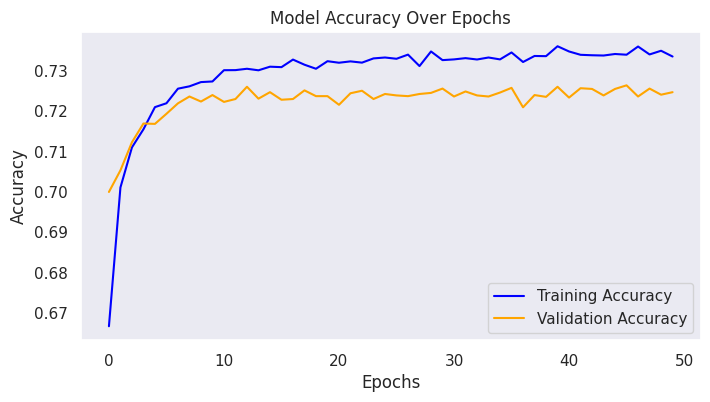

In [43]:
plt.figure(figsize=(8, 4))
plt.plot(history_scaled.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_scaled.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

**Inferences:**<br>
**Initial Training:**<br>
The model starts with an accuracy of 0.6354 and a loss of 0.6461.
The validation accuracy is slightly higher at 0.7000, indicating that the model is generalizing reasonably well.

**Training Progress:**<br>
As the training progresses, both the training and validation accuracy gradually increase.
The loss decreases steadily, suggesting that the model is learning to make better predictions.<br>
The final training accuracy is 0.7337, and the validation accuracy is 0.7247.<br>
The model's accuracy on the standard scaled test set is 0.7326.<br>
**Model Performance:** The model has achieved a reasonable level of accuracy on both the training and validation sets. The test accuracy however suggests that it may be overfitting the data.

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6833 - loss: 0.6063 - val_accuracy: 0.7268 - val_loss: 0.5715
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7231 - loss: 0.5660 - val_accuracy: 0.7303 - val_loss: 0.5695
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7232 - loss: 0.5679 - val_accuracy: 0.7297 - val_loss: 0.5692
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7249 - loss: 0.5656 - val_accuracy: 0.7297 - val_loss: 0.5689
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7206 - loss: 0.5719 - val_accuracy: 0.7304 - val_loss: 0.5688
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7267 - loss: 0.5670 - val_accuracy: 0.7305 - val_loss: 0.5690
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7226 - loss: 0.5696 - val_accuracy: 0.7300 - val_loss: 0.5687
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7215 - loss: 0.5670 - val_accurac

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5680 - loss: 0.7899 - val_accuracy: 0.6896 - val_loss: 0.6069
Epoch 2/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7109 - loss: 0.5883 - val_accuracy: 0.7253 - val_loss: 0.5730
Epoch 3/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7247 - loss: 0.5677 - val_accuracy: 0.7312 - val_loss: 0.5678
Epoch 4/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7255 - loss: 0.5672 - val_accuracy: 0.7317 - val_loss: 0.5671
Epoch 5/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7250 - loss: 0.5667 - val_accuracy: 0.7309 - val_loss: 0.5670
Epoch 6/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7257 - loss: 0.5690 - val_accuracy: 0.7304 - val_loss: 0.5672
Epoch 7/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7272 - loss: 0.5690 - val_accuracy: 0.7310 - val_loss: 0.5670
Epoch 8/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7264 - loss: 0.5634 - val_accuracy: 0.7310 - val_

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2734/2734 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5783 - loss: 0.7168 - val_accuracy: 0.7230 - val_loss: 0.5706
Epoch 2/10
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7202 - loss: 0.5753 - val_accuracy: 0.7288 - val_loss: 0.5678
Epoch 3/10
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7257 - loss: 0.5661 - val_accuracy: 0.7307 - val_loss: 0.5674
Epoch 4/10
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7270 - loss: 0.5640 - val_accuracy: 0.7322 - val_loss: 0.5673
Epoch 5/10
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7237 - loss: 0.5665 - val_accuracy: 0.7305 - val_loss: 0.5673
Epoch 6/10
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7256 - loss: 0.5662 - val_accuracy: 0.7306 - val_loss: 0.5671
Epoch 7/10
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7279 - loss: 0.5673 - val_accuracy: 0.7299 - val_loss: 0.5668
Epoch 8/10
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7246 - loss: 0.5673 - val_acc

**Inference:**

Changing batch sizes provides a neglible change in Accuracy. There is a similiar affect on other metrics as well.

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.5)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


855/855 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5113 - loss: 0.8626 - val_accuracy: 0.6467 - val_loss: 0.6348
Epoch 2/10
855/855 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6755 - loss: 0.6080 - val_accuracy: 0.7061 - val_loss: 0.5826
Epoch 3/10
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7143 - loss: 0.5720 - val_accuracy: 0.7191 - val_loss: 0.5740
Epoch 4/10
855/855 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7264 - loss: 0.5636 - val_accuracy: 0.7217 - val_loss: 0.5716
Epoch 5/10
855/855 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7286 - loss: 0.5645 - val_accuracy: 0.7237 - val_loss: 0.5709
Epoch 6/10
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7256 - loss: 0.5651 - val_accuracy: 0.7241 - val_loss: 0.5709
Epoch 7/10
855/855 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7234 - loss: 0.5646 - val_accuracy: 0.7238 - val_loss: 0.5709
Epoch 8/10
855/855 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7276 - loss: 0.5647 - val_accuracy: 0.7228 - va

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.3)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6175 - loss: 0.7208 - val_accuracy: 0.7234 - val_loss: 0.5734
Epoch 2/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7202 - loss: 0.5730 - val_accuracy: 0.7281 - val_loss: 0.5684
Epoch 3/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7213 - loss: 0.5734 - val_accuracy: 0.7275 - val_loss: 0.5683
Epoch 4/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7184 - loss: 0.5720 - val_accuracy: 0.7283 - val_loss: 0.5683
Epoch 5/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7241 - loss: 0.5684 - val_accuracy: 0.7276 - val_loss: 0.5685
Epoch 6/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7237 - loss: 0.5687 - val_accuracy: 0.7269 - val_loss: 0.5684
Epoch 7/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7269 - loss: 0.5688 - val_accuracy: 0.7289 - val_loss: 0.5684
Epoch 8/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7216 - loss: 0.5712 - val_accurac

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5181 - loss: 0.8327 - val_accuracy: 0.7050 - val_loss: 0.5924
Epoch 2/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7104 - loss: 0.5817 - val_accuracy: 0.7290 - val_loss: 0.5725
Epoch 3/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7233 - loss: 0.5681 - val_accuracy: 0.7324 - val_loss: 0.5706
Epoch 4/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7223 - loss: 0.5695 - val_accuracy: 0.7330 - val_loss: 0.5696
Epoch 5/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7252 - loss: 0.5678 - val_accuracy: 0.7332 - val_loss: 0.5690
Epoch 6/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7247 - loss: 0.5680 - val_accuracy: 0.7352 - val_loss: 0.5689
Epoch 7/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7237 - loss: 0.5666 - val_accuracy: 0.7330 - val_loss: 0.5683
Epoch 8/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7202 - loss: 0.5729 - 

**Inference:**

Changing validation split does not affect accuracy. Similiarly no effect on other factors

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5032 - loss: 0.8430 - val_accuracy: 0.7120 - val_loss: 0.5830
Epoch 2/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7106 - loss: 0.5800 - val_accuracy: 0.7271 - val_loss: 0.5693
Epoch 3/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7201 - loss: 0.5724 - val_accuracy: 0.7296 - val_loss: 0.5675
Epoch 4/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7267 - loss: 0.5655 - val_accuracy: 0.7304 - val_loss: 0.5671
Epoch 5/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7247 - loss: 0.5686 - val_accuracy: 0.7295 - val_loss: 0.5668
428/428 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7204 - loss: 0.5695
Test Accuracy: 0.7250

Accuracy: 0.7247
Precision: 0.7475
Recall: 0.6720
F1 Score: 0.7078
Confusion Matrix:
[[5348 1539]
 [2224 4557]]


In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_split=0.1)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6114 - loss: 0.6932 - val_accuracy: 0.7330 - val_loss: 0.5670
Epoch 2/15
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7230 - loss: 0.5653 - val_accuracy: 0.7339 - val_loss: 0.5664
Epoch 3/15
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7204 - loss: 0.5670 - val_accuracy: 0.7334 - val_loss: 0.5661
Epoch 4/15
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7219 - loss: 0.5711 - val_accuracy: 0.7341 - val_loss: 0.5662
Epoch 5/15
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7254 - loss: 0.5658 - val_accuracy: 0.7330 - val_loss: 0.5662
Epoch 6/15
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7242 - loss: 0.5678 - val_accuracy: 0.7319 - val_loss: 0.5661
Epoch 7/15
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7282 - loss: 0.5633 - val_accuracy: 0.7337 - val_loss: 0.5659
Epoch 8/15
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7241 - loss: 0.5689 

**Inference:**

Changing number of epochs does not affect accuracy. Other metrics are also similiarly unaffected

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6995 - loss: 0.5859 - val_accuracy: 0.7336 - val_loss: 0.5497
Epoch 2/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7261 - loss: 0.5506 - val_accuracy: 0.7335 - val_loss: 0.5452
Epoch 3/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7328 - loss: 0.5453 - val_accuracy: 0.7357 - val_loss: 0.5444
Epoch 4/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7287 - loss: 0.5487 - val_accuracy: 0.7404 - val_loss: 0.5424
Epoch 5/5
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7340 - loss: 0.5419 - val_accuracy: 0.7395 - val_loss: 0.5412
428/428 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7307 - loss: 0.5487
Test Accuracy: 0.7326
428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Accuracy: 0.7326
Precision: 0.7615
Recall: 0.6713
F1 Score: 0.7135
Confusion Matrix:
[[5461 1426]
 [2229 4552]]


In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(128, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1367/1367 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7106 - loss: 0.5712 - val_accuracy: 0.7366 - val_loss: 0.5461
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7339 - loss: 0.5472 - val_accuracy: 0.7383 - val_loss: 0.5431
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7300 - loss: 0.5479 - val_accuracy: 0.7374 - val_loss: 0.5441
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7326 - loss: 0.5425 - val_accuracy: 0.7369 - val_loss: 0.5411
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7345 - loss: 0.5409 - val_accuracy: 0.7386 - val_loss: 0.5395
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7347 - loss: 0.5427 - val_accuracy: 0.7401 - val_loss: 0.5433
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7320 - loss: 0.5420 - val_accuracy: 0.7390 - val_loss: 0.5397
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7347 - loss: 0.5413 - val_accur

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(64, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7151 - loss: 0.5693 - val_accuracy: 0.7360 - val_loss: 0.5472
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7294 - loss: 0.5501 - val_accuracy: 0.7386 - val_loss: 0.5420
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7313 - loss: 0.5450 - val_accuracy: 0.7378 - val_loss: 0.5437
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7301 - loss: 0.5460 - val_accuracy: 0.7377 - val_loss: 0.5445
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7341 - loss: 0.5429 - val_accuracy: 0.7395 - val_loss: 0.5439
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7315 - loss: 0.5438 - val_accuracy: 0.7373 - val_loss: 0.5411
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7338 - loss: 0.5414 - val_accuracy: 0.7370 - val_loss: 0.5400
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7354 - loss: 0.5403 - val_accurac

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6603 - loss: 0.6150 - val_accuracy: 0.7311 - val_loss: 0.5506
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7275 - loss: 0.5514 - val_accuracy: 0.7341 - val_loss: 0.5454
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7295 - loss: 0.5492 - val_accuracy: 0.7342 - val_loss: 0.5440
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7270 - loss: 0.5503 - val_accuracy: 0.7391 - val_loss: 0.5412
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7333 - loss: 0.5419 - val_accuracy: 0.7412 - val_loss: 0.5407
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7300 - loss: 0.5456 - val_accuracy: 0.7412 - val_loss: 0.5396
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7305 - loss: 0.5459 - val_accuracy: 0.7384 - val_loss: 0.5412
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7322 - loss: 0.5431 - 

**Inference:**

Adding a new of a relu activation neurons increases accuracy slightly. 64 layers for the input and hidden layers provides the highest recall, which is desirable. Accuracy remains similiar

In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.1),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.1),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7018 - loss: 0.5797 - val_accuracy: 0.7396 - val_loss: 0.5485
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7310 - loss: 0.5514 - val_accuracy: 0.7372 - val_loss: 0.5446
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7260 - loss: 0.5545 - val_accuracy: 0.7398 - val_loss: 0.5406
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7305 - loss: 0.5504 - val_accuracy: 0.7383 - val_loss: 0.5417
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7336 - loss: 0.5480 - val_accuracy: 0.7365 - val_loss: 0.5406
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7355 - loss: 0.5453 - val_accuracy: 0.7382 - val_loss: 0.5403
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7298 - loss: 0.5469 - val_accuracy: 0.7417 - val_loss: 0.5399
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7283 - loss: 0.5456 - val_accura

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1367/1367 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.6989 - loss: 0.5868 - val_accuracy: 0.7378 - val_loss: 0.5503
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7253 - loss: 0.5561 - val_accuracy: 0.7391 - val_loss: 0.5437
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7269 - loss: 0.5551 - val_accuracy: 0.7370 - val_loss: 0.5445
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7278 - loss: 0.5530 - val_accuracy: 0.7381 - val_loss: 0.5404
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7313 - loss: 0.5488 - val_accuracy: 0.7411 - val_loss: 0.5420
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7317 - loss: 0.5494 - val_accuracy: 0.7381 - val_loss: 0.5398
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7333 - loss: 0.5468 - val_accuracy: 0.7383 - val_loss: 0.5397
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7300 - loss: 0.5485 - val_accur

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6922 - loss: 0.5903 - val_accuracy: 0.7370 - val_loss: 0.5471
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7273 - loss: 0.5584 - val_accuracy: 0.7354 - val_loss: 0.5457
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7279 - loss: 0.5534 - val_accuracy: 0.7394 - val_loss: 0.5410
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7293 - loss: 0.5518 - val_accuracy: 0.7358 - val_loss: 0.5428
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7251 - loss: 0.5544 - val_accuracy: 0.7385 - val_loss: 0.5417
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7258 - loss: 0.5539 - val_accuracy: 0.7388 - val_loss: 0.5409
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7334 - loss: 0.5455 - val_accuracy: 0.7396 - val_loss: 0.5388
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7321 - loss: 0.5478 -

**Inference:**

Changing Dropout to 0.2 increases recall for small change in accuracy, thus we choose dropout 0.2

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6945 - loss: 0.5955 - val_accuracy: 0.7367 - val_loss: 0.5483
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7209 - loss: 0.5652 - val_accuracy: 0.7384 - val_loss: 0.5442
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7302 - loss: 0.5530 - val_accuracy: 0.7330 - val_loss: 0.5440
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7240 - loss: 0.5547 - val_accuracy: 0.7388 - val_loss: 0.5422
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7349 - loss: 0.5487 - val_accuracy: 0.7363 - val_loss: 0.5422
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7326 - loss: 0.5487 - val_accuracy: 0.7377 - val_loss: 0.5412
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7396 - loss: 0.5425 - val_accuracy: 0.7372 - val_loss: 0.5414
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7333 - loss: 0.5451 

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6750 - loss: 0.6099 - val_accuracy: 0.7336 - val_loss: 0.5551
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7248 - loss: 0.5661 - val_accuracy: 0.7359 - val_loss: 0.5491
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7283 - loss: 0.5579 - val_accuracy: 0.7379 - val_loss: 0.5462
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7254 - loss: 0.5571 - val_accuracy: 0.7394 - val_loss: 0.5434
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7300 - loss: 0.5544 - val_accuracy: 0.7382 - val_loss: 0.5432
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7270 - loss: 0.5553 - val_accuracy: 0.7384 - val_loss: 0.5411
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7293 - loss: 0.5526 - val_accuracy: 0.7394 - val_loss: 0.5399
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7270 - loss: 0.5561 -

Increasing number of further nodes does not imporve metrics

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop(columns=['cardio','index','id','Hypertension'], axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_scaled = (model.predict(X_test_scaled) > 0.5).astype("int32")

predictions_binary = y_pred_scaled

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - Recall: 0.6792 - loss: 0.5824 - val_Recall: 0.7036 - val_loss: 0.5456
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - Recall: 0.6923 - loss: 0.5541 - val_Recall: 0.6641 - val_loss: 0.5432
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - Recall: 0.6776 - loss: 0.5555 - val_Recall: 0.6869 - val_loss: 0.5412
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - Recall: 0.6863 - loss: 0.5495 - val_Recall: 0.6865 - val_loss: 0.5411
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - Recall: 0.6906 - loss: 0.5487 - val_Recall: 0.6856 - val_loss: 0.5403
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - Recall: 0.6805 - loss: 0.5481 - val_Recall: 0.6897 - val_loss: 0.5395
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - Recall: 0.6800 - loss: 0.5515 - val_Recall: 0.6574 - val_loss: 0.5406
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - Recall: 0.6781 - loss: 0.5492 - val_Recall: 0.7027 - val_los

changing the evaluation metric to recall does not affect recall, in fact it is worsened

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming zscore_df is your preprocessed DataFrame with the necessary columns.
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    zscore_df.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1),
    zscore_df['cardio'],
    test_size=0.2,
    random_state=42
)

# Standardize the feature sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and convert them to binary
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Create a DataFrame to display comparison of true vs predicted values, with features for a sample of 100
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

X_test_df = pd.DataFrame(X_test[:100], columns=X_train.columns).reset_index(drop=True)
y_test_df = y_test[:100].reset_index(drop=True)

# Create the comparison DataFrame with y_test and predictions
comparison_df = pd.DataFrame({
    'y_test': y_test_df,
    'predictions': predictions.flatten()[:100]
}).reset_index(drop=True)

comparison_df_full = pd.concat([X_test_df, comparison_df], axis=1)
print(comparison_df_full.to_string())


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7019 - loss: 0.5846 - val_accuracy: 0.7349 - val_loss: 0.5497
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7261 - loss: 0.5622 - val_accuracy: 0.7395 - val_loss: 0.5434
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7272 - loss: 0.5545 - val_accuracy: 0.7400 - val_loss: 0.5411
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7332 - loss: 0.5473 - val_accuracy: 0.7356 - val_loss: 0.5406
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7302 - loss: 0.5506 - val_accuracy: 0.7393 - val_loss: 0.5410
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7294 - loss: 0.5523 - val_accuracy: 0.7409 - val_loss: 0.5383
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7306 - loss: 0.5505 - val_accuracy: 0.7381 - val_loss: 0.5396
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7330 - loss: 0.5486 - val_accurac

**Inference:**

An Optimal model was found with purely scaled data on Logistic Regression with 2 layers of relu acitvated neurons and a logistic regression output layer. this gives an accuracy between 73 and 73.5% by the system. The Recall has also been improved to 70% from 66% before optimzations

Model Evaluation (Anomaly Detection):

Anomaly Detection is our own method of detecting the accuracy of the system. It is a system where the actual value provided by the model is converted into 3 classifications:

Well Predicted (The prediction and actual value differ by less than 0.4)

Ambigous (differs between 0.4 and 0.6)

Anomaly (differs by greater than 0.6)

**Result:**


The Current Model gets around 70 well predicted values and the rest being an even distribution of anomalies and ambigous predictions. This shows that while the model is capable, it still requires fine tuning

Another thing to be noticed is that these anomalies are truly anomalies, even in the medical field, ie they are very unhealthy and likely to get a CVD but havent gotten it through happenstance which may suggest that genetic or mental factors may be at play that our dataset simply has not covered.

TensorFlow+min-max scaling

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6126 - loss: 0.6532 - val_accuracy: 0.6478 - val_loss: 0.6268
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6418 - loss: 0.6288 - val_accuracy: 0.6517 - val_loss: 0.6228
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6504 - loss: 0.6253 - val_accuracy: 0.6553 - val_loss: 0.6211
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6452 - loss: 0.6283 - val_accuracy: 0.6466 - val_loss: 0.6241
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6471 - loss: 0.6257 - val_accuracy: 0.6464 - val_loss: 0.6233
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6548 - loss: 0.6199 - val_accuracy: 0.6524 - val_loss: 0.6235
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6523 - loss: 0.6209 - val_accuracy: 0.6574 - val_loss: 0.6171
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6512 - loss: 0.6242 -

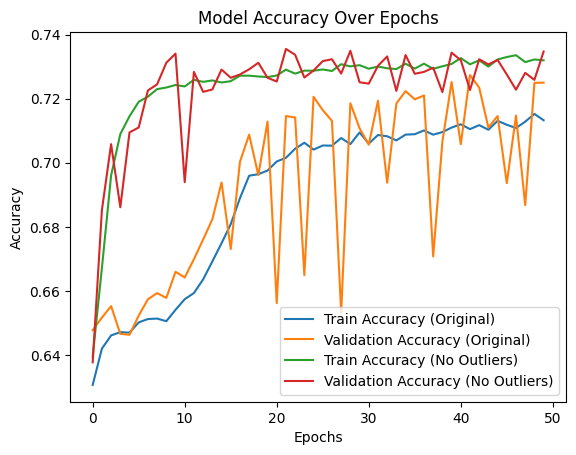

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
# Remove outliers in the specified columns
columns = ['weight', 'ap_lo', 'ap_hi']
df_no_outliers = df.copy()

for col in columns:
    high = df_no_outliers[col].mean() + 3 * df_no_outliers[col].std()
    low = df_no_outliers[col].mean() - 3 * df_no_outliers[col].std()
    df_no_outliers = df_no_outliers[(df_no_outliers[col] < high) & (df_no_outliers[col] > low)]

# Remove outliers in the specified columns
columns = ['weight', 'ap_lo', 'ap_hi']
df_no_outliers = df.copy()

for col in columns:
    high = df_no_outliers[col].mean() + 3 * df_no_outliers[col].std()
    low = df_no_outliers[col].mean() - 3 * df_no_outliers[col].std()
    df_no_outliers = df_no_outliers[(df_no_outliers[col] < high) & (df_no_outliers[col] > low)]

# Define target and features
target_column = 'cardio'
X = df.drop(target_column, axis=1)
y = df[target_column]

# Split without outliers
X_no_outliers = df_no_outliers.drop(target_column, axis=1)
y_no_outliers = df_no_outliers[target_column]

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_no_outliers_scaled = scaler.fit_transform(X_train_no_outliers)
X_test_no_outliers_scaled = scaler.transform(X_test_no_outliers)

# Define the model architecture
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train model with original data
model_original = create_model()
history_original = model_original.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test), verbose=1)

# Train model with data without outliers
model_no_outliers = create_model()
history_no_outliers = model_no_outliers.fit(X_train_no_outliers_scaled, y_train_no_outliers, epochs=50,
                                            validation_data=(X_test_no_outliers_scaled, y_test_no_outliers), verbose=1)

# Evaluate accuracy on the original data
loss, accuracy_original = model_original.evaluate(X_test_scaled, y_test)
print("Accuracy with original data:", accuracy_original)

# Evaluate accuracy on the data without outliers
loss, accuracy_no_outliers = model_no_outliers.evaluate(X_test_no_outliers_scaled, y_test_no_outliers)
print("Accuracy without outliers:", accuracy_no_outliers)

# Plot accuracy over epochs
plt.plot(history_original.history['accuracy'], label='Train Accuracy (Original)')
plt.plot(history_original.history['val_accuracy'], label='Validation Accuracy (Original)')
plt.plot(history_no_outliers.history['accuracy'], label='Train Accuracy (No Outliers)')
plt.plot(history_no_outliers.history['val_accuracy'], label='Validation Accuracy (No Outliers)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

**Inference:**<br>
The model achieved an accuracy of approximately 71.7% on the original data with outliers.
After removing outliers, the model's accuracy increased to around 73.4%.
This suggests that removing outliers helped the model generalize better, possibly because outliers can distort the feature space, making it harder for the model to learn consistent patterns. Without these outliers, the model likely focused more on the core patterns within the data.

**Training and Validation Trends:**<br>
During training, the validation accuracy fluctuated but generally increased over the epochs, which is expected as the model learns from the data.
The accuracy on both training and validation sets shows a gradual improvement, indicating the model is effectively learning patterns without overfitting significantly, as seen by the similar performance on both sets.<br>
In summary, removing outliers had a positive effect on model performance, highlighting the importance of data preprocessing and cleaning in machine learning. This step helped the neural network achieve slightly better generalization, suggesting that the model could further improve with additional data tuning and preprocessing steps.

TensorFlow + Zscore method

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5044 - loss: 110.0147 - val_accuracy: 0.4954 - val_loss: 153.4078
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5118 - loss: 51.0916 - val_accuracy: 0.5094 - val_loss: 49.7601
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5140 - loss: 36.1569 - val_accuracy: 0.5477 - val_loss: 6.8609
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5257 - loss: 25.6455 - val_accuracy: 0.5028 - val_loss: 31.8781
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5341 - loss: 17.1754 - val_accuracy: 0.5211 - val_loss: 7.4905
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5336 - loss: 15.6245 - val_accuracy: 0.5291 - val_loss: 5.5385
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5375 - loss: 13.6024 - val_accuracy: 0.5518 - val_loss: 5.5069
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5518 - loss: 10.1404 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1709/1709 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5135 - loss: 76.5197 - val_accuracy: 0.5020 - val_loss: 32.8415
Epoch 2/50
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5256 - loss: 43.2908 - val_accuracy: 0.5132 - val_loss: 48.0316
Epoch 3/50
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5184 - loss: 44.2522 - val_accuracy: 0.5309 - val_loss: 30.3032
Epoch 4/50
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5330 - loss: 29.2178 - val_accuracy: 0.4996 - val_loss: 95.4230
Epoch 5/50
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5409 - loss: 28.7573 - val_accuracy: 0.5029 - val_loss: 49.8649
Epoch 6/50
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5435 - loss: 25.0736 - val_accuracy: 0.5353 - val_loss: 16.7037
Epoch 7/50
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5487 - loss: 18.3252 - val_accuracy: 0.6584 - val_loss: 2.6241
Epoch 8/50
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5598 - loss: 14.6978

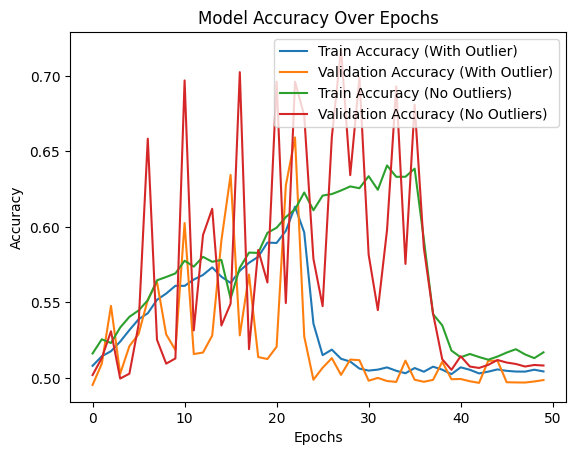

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

#Removing the outlier using z-score
column=['weight','ap_lo','ap_hi']
zscore_df=df
#Filter Out Outliers, keeping only the rows where values in the column are within the high and low bounds (i.e., not outliers).
for cols in column:
    high=zscore_df[cols].mean() + 3*zscore_df[cols].std();
    low=zscore_df[cols].mean() - 3*zscore_df[cols].std()
    zscore_df = zscore_df[(zscore_df[cols] < high) & (zscore_df[cols] > low)]

X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1),
                                                    df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)
X_train_no_outliers , X_test_no_outliers,y_train_no_outliers,y_test_no_outliers =train_test_split(zscore_df.drop('cardio', axis=1),
                                                    zscore_df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)

# Define the model architecture
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train model with original data
model_original = create_model()
history_original = model_original.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# Train model with data without outliers using zscore method
model_no_outliers = create_model()
history_no_outliers = model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers, epochs=50,
                                            validation_data=(X_test_no_outliers, y_test_no_outliers), verbose=1)

# Evaluate accuracy on the original data
loss, accuracy_original = model_original.evaluate(X_test, y_test)
print("Accuracy with original data:", accuracy_original)

# Evaluate accuracy on the data without outliers
loss, accuracy_no_outliers = model_no_outliers.evaluate(X_test_no_outliers, y_test_no_outliers)
print("Accuracy without outliers using zscore:", accuracy_no_outliers)

# Plot accuracy over epochs
plt.plot(history_original.history['accuracy'], label='Train Accuracy (With Outlier)')
plt.plot(history_original.history['val_accuracy'], label='Validation Accuracy (With Outlier)')
plt.plot(history_no_outliers.history['accuracy'], label='Train Accuracy (No Outliers)')
plt.plot(history_no_outliers.history['val_accuracy'], label='Validation Accuracy (No Outliers)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

**Inference**:

The model achieved an accuracy of approximately 49.9% on the original data with outliers. After removing outliers using the Z-score method, the model's accuracy increased slightly to around 50.8%. This small improvement suggests that the outliers have contributed to some noise in the data, slightly hindering the model's ability to generalize.

**Training and Validation Trends**:

Looking at the accuracy trends over the epochs in the plot, we see notable fluctuations in both training and validation accuracies. The validation accuracy, especially on the dataset without outliers, shows high variability and occasional spikes.

The model’s performance across training and validation sets does not consistently improve, and there are sharp changes, particularly in the validation set. This suggests that the neural network might be overfitting, especially since it fails to achieve higher validation accuracy.

**TensorFlow + IQR method**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5105 - loss: 87.1026 - val_accuracy: 0.5164 - val_loss: 30.7640
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5244 - loss: 49.1696 - val_accuracy: 0.5787 - val_loss: 4.8016
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5213 - loss: 36.3171 - val_accuracy: 0.6819 - val_loss: 1.4843
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5370 - loss: 24.5951 - val_accuracy: 0.6338 - val_loss: 1.7325
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5411 - loss: 19.2203 - val_accuracy: 0.5027 - val_loss: 45.3818
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5510 - loss: 14.2291 - val_accuracy: 0.5201 - val_loss: 15.1596
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5394 - loss: 14.5269 - val_accuracy: 0.5189 - val_loss: 8.8389
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5460 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1613/1613 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4960 - loss: 170.8577 - val_accuracy: 0.5091 - val_loss: 11.0361
Epoch 2/50
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5099 - loss: 21.7832 - val_accuracy: 0.5033 - val_loss: 14.3069
Epoch 3/50
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5226 - loss: 18.0579 - val_accuracy: 0.5157 - val_loss: 10.7596
Epoch 4/50
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5184 - loss: 19.6278 - val_accuracy: 0.5372 - val_loss: 6.4029
Epoch 5/50
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5166 - loss: 15.5351 - val_accuracy: 0.5042 - val_loss: 17.1229
Epoch 6/50
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5254 - loss: 14.6203 - val_accuracy: 0.5073 - val_loss: 16.4266
Epoch 7/50
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5332 - loss: 10.3514 - val_accuracy: 0.6062 - val_loss: 1.7379
Epoch 8/50
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5415 - loss: 8.2744

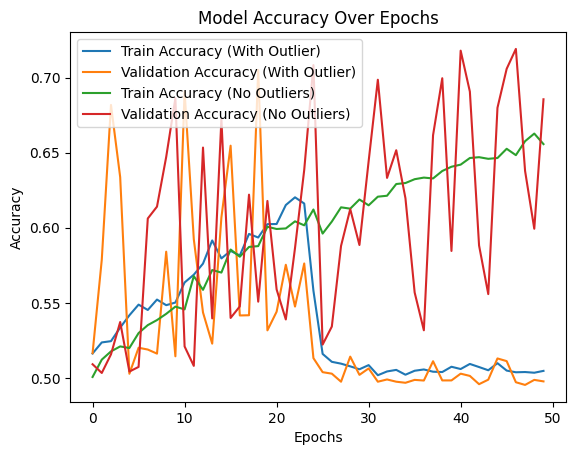

In [ ]:
column=['ap_lo','ap_hi']
IQR_df=df
for cols in column:
    # Finding the IQR
    Q1= IQR_df[cols].quantile(0.25)
    Q3 = IQR_df[cols].quantile(0.75)
    iqr = Q3-Q1
    upper_limit = Q3 + 1.5 * iqr
    lower_limit = Q1 - 1.5 * iqr
    IQR_df=IQR_df[(IQR_df[cols] >= lower_limit) & (IQR_df[cols] <= upper_limit)]
# It splits both the original data (df) and the cleaned data (IQR_df) into training and testing sets.
# X_train and y_train are the training features and labels from the original data, while X_train_scaled and y_train_scaled are from the cleaned data.
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1),
                                                    df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)

X_train_no_outliers , X_test_no_outliers,y_train_no_outliers,y_test_no_outliers =train_test_split(IQR_df.drop('cardio', axis=1),
                                                    IQR_df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)

# Define the model architecture
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train model with original data
model_original = create_model()
history_original = model_original.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# Train model with data without outliers using IQR method
model_no_outliers = create_model()
history_no_outliers = model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers, epochs=50,
                                            validation_data=(X_test_no_outliers, y_test_no_outliers), verbose=1)

# Evaluate accuracy on the original data
loss, accuracy_original = model_original.evaluate(X_test, y_test)
print("Accuracy with original data:", accuracy_original)

# Evaluate accuracy on the data without outliers
loss, accuracy_no_outliers = model_no_outliers.evaluate(X_test_no_outliers, y_test_no_outliers)
print("Accuracy without outliers using zscore:", accuracy_no_outliers)

# Plot accuracy over epochs
plt.plot(history_original.history['accuracy'], label='Train Accuracy (With Outlier)')
plt.plot(history_original.history['val_accuracy'], label='Validation Accuracy (With Outlier)')
plt.plot(history_no_outliers.history['accuracy'], label='Train Accuracy (No Outliers)')
plt.plot(history_no_outliers.history['val_accuracy'], label='Validation Accuracy (No Outliers)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

**Accuracy:**

The model achieved an accuracy of approximately 49.76% on the original dataset with outliers, indicating moderate performance.After removing outliers using the IQR method, the model's accuracy significantly increased to around 68.56%, suggesting that outlier removal positively impacted model performance by allowing it to focus on the core patterns in the data.

**Training and Validation Trends:**

With Outliers: The training and validation accuracy curves (blue and orange lines) show lower accuracy and more fluctuations, particularly in validation, suggesting instability in the model’s performance with noisy data.

Without Outliers (IQR): Similar to the Z-score method, this approach also seems to stabilize the model and improve its accuracy over epochs.


**Results:**

Removing outliers, whether through the Z-score or IQR methods, enabled the model to learn more reliable patterns by excluding extreme values that could distort the feature space.

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming zscore_df is your preprocessed DataFrame with the necessary columns.
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    zscore_df.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1),
    zscore_df['cardio'],
    test_size=0.2,
    random_state=42
)

# Standardize the feature sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and convert them to binary
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

X_scaled = scaler.transform(zscore_df.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1))
predictions = model.predict(X_scaled)

# Convert predictions to a flattened array
predictions_flat = predictions.flatten()

# Define outlier conditions based on your criteria
outliers = ((predictions_flat > 0.9) & (zscore_df['cardio'] == 0)) | ((predictions_flat < 0.1) & (zscore_df['cardio'] == 1))

filtered_indices = ~outliers
filtered_data = zscore_df[filtered_indices]

print(zscore_df[outliers].head(100).to_string())
print("Filtered Data Shape:", filtered_data.shape)

X_train, X_test, y_train, y_test = train_test_split(
    filtered_data.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1),
    filtered_data['cardio'],
    test_size=0.2,
    random_state=42
)

# Standardize the feature sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and convert them to binary
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6935 - loss: 0.5896 - val_accuracy: 0.7349 - val_loss: 0.5487
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7270 - loss: 0.5573 - val_accuracy: 0.7392 - val_loss: 0.5441
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7280 - loss: 0.5528 - val_accuracy: 0.7369 - val_loss: 0.5432
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7301 - loss: 0.5475 - val_accuracy: 0.7375 - val_loss: 0.5412
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7256 - loss: 0.5548 - val_accuracy: 0.7378 - val_loss: 0.5403
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7330 - loss: 0.5478 - val_accuracy: 0.7399 - val_loss: 0.5407
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7350 - loss: 0.5457 - val_accuracy: 0.7397 - val_loss: 0.5400
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7316 - loss: 0.5445 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1362/1362 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7061 - loss: 0.5806 - val_accuracy: 0.7412 - val_loss: 0.5369
Epoch 2/10
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7280 - loss: 0.5472 - val_accuracy: 0.7389 - val_loss: 0.5359
Epoch 3/10
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7293 - loss: 0.5442 - val_accuracy: 0.7425 - val_loss: 0.5344
Epoch 4/10
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7346 - loss: 0.5411 - val_accuracy: 0.7413 - val_loss: 0.5332
Epoch 5/10
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7349 - loss: 0.5408 - val_accuracy: 0.7437 - val_loss: 0.5305
Epoch 6/10
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7333 - loss: 0.5396 - val_accuracy: 0.7415 - val_loss: 0.5314
Epoch 7/10
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7327 - loss: 0.5412 - val_accuracy: 0.7425 - val_loss: 0.5307
Epoch 8/10
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7333 - loss: 0.5404 - val_accurac

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming zscore_df is your preprocessed DataFrame with the necessary columns.
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    zscore_df.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1),
    zscore_df['cardio'],
    test_size=0.2,
    random_state=42
)

# Standardize the feature sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and convert them to binary
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

X_scaled = scaler.transform(zscore_df.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1))
predictions = model.predict(X_scaled)

# Convert predictions to a flattened array
predictions_flat = predictions.flatten()

# Define outlier conditions based on your criteria
outliers = ((predictions_flat > 0.9) & (zscore_df['cardio'] == 0)) | ((predictions_flat < 0.1) & (zscore_df['cardio'] == 1))

filtered_indices = ~outliers
filtered_data = zscore_df[filtered_indices]

print(zscore_df[outliers].head(100).to_string())
print("Filtered Data Shape:", filtered_data.shape)

X_train, X_test, y_train, y_test = train_test_split(
    filtered_data.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1),
    filtered_data['cardio'],
    test_size=0.2,
    random_state=42
)

# Standardize the feature sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and convert them to binary
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6765 - loss: 0.6013 - val_accuracy: 0.7310 - val_loss: 0.5506
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7237 - loss: 0.5562 - val_accuracy: 0.7379 - val_loss: 0.5454
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7281 - loss: 0.5498 - val_accuracy: 0.7395 - val_loss: 0.5435
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7246 - loss: 0.5518 - val_accuracy: 0.7383 - val_loss: 0.5422
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7319 - loss: 0.5440 - val_accuracy: 0.7387 - val_loss: 0.5422
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7305 - loss: 0.5458 - val_accuracy: 0.7372 - val_loss: 0.5417
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7281 - loss: 0.5473 - val_accuracy: 0.7406 - val_loss: 0.5410
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7331 - loss: 0.5446 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1359/1359 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6968 - loss: 0.5815 - val_accuracy: 0.7271 - val_loss: 0.5450
Epoch 2/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7348 - loss: 0.5412 - val_accuracy: 0.7278 - val_loss: 0.5414
Epoch 3/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7371 - loss: 0.5361 - val_accuracy: 0.7284 - val_loss: 0.5403
Epoch 4/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7350 - loss: 0.5362 - val_accuracy: 0.7293 - val_loss: 0.5391
Epoch 5/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7379 - loss: 0.5314 - val_accuracy: 0.7306 - val_loss: 0.5385
Epoch 6/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7366 - loss: 0.5332 - val_accuracy: 0.7289 - val_loss: 0.5376
Epoch 7/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7377 - loss: 0.5326 - val_accuracy: 0.7296 - val_loss: 0.5409
Epoch 8/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7391 - loss: 0.5304 - val_accurac

In [92]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming zscore_df is your preprocessed DataFrame with the necessary columns.
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    zscore_df.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1),
    zscore_df['cardio'],
    test_size=0.2,
    random_state=42
)

# Standardize the feature sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and convert them to binary
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

X_scaled = scaler.transform(zscore_df.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1))
predictions = model.predict(X_scaled)

# Convert predictions to a flattened array
predictions_flat = predictions.flatten()

# Define outlier conditions based on your criteria
outliers = ((predictions_flat > 0.8) & (zscore_df['cardio'] == 0)) | ((predictions_flat < 0.2) & (zscore_df['cardio'] == 1))

filtered_indices = ~outliers
filtered_data = zscore_df[filtered_indices]

print(zscore_df[outliers].head(100).to_string())
print("Filtered Data Shape:", filtered_data.shape)

X_train, X_test, y_train, y_test = train_test_split(
    filtered_data.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1),
    filtered_data['cardio'],
    test_size=0.2,
    random_state=42
)

# Standardize the feature sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and convert them to binary
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1367/1367 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6958 - loss: 0.5881 - val_accuracy: 0.7348 - val_loss: 0.5488
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7225 - loss: 0.5606 - val_accuracy: 0.7390 - val_loss: 0.5439
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7303 - loss: 0.5511 - val_accuracy: 0.7351 - val_loss: 0.5444
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7273 - loss: 0.5540 - val_accuracy: 0.7383 - val_loss: 0.5416
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7300 - loss: 0.5496 - val_accuracy: 0.7365 - val_loss: 0.5417
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7305 - loss: 0.5508 - val_accuracy: 0.7397 - val_loss: 0.5399
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7324 - loss: 0.5462 - val_accuracy: 0.7393 - val_loss: 0.5390
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7313 - loss: 0.5483 - val_accura

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7426 - loss: 0.5021 - val_accuracy: 0.7709 - val_loss: 0.4440
Epoch 2/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7691 - loss: 0.4563 - val_accuracy: 0.7707 - val_loss: 0.4386
Epoch 3/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7703 - loss: 0.4477 - val_accuracy: 0.7733 - val_loss: 0.4368
Epoch 4/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7710 - loss: 0.4424 - val_accuracy: 0.7736 - val_loss: 0.4361
Epoch 5/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7701 - loss: 0.4449 - val_accuracy: 0.7738 - val_loss: 0.4334
Epoch 6/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7712 - loss: 0.4413 - val_accuracy: 0.7736 - val_loss: 0.4335
Epoch 7/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7697 - loss: 0.4402 - val_accuracy: 0.7727 - val_loss: 0.4305
Epoch 8/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7729 - loss: 0.4348 - val_accurac

In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming zscore_df is your preprocessed DataFrame with the necessary columns.
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    zscore_df.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1),
    zscore_df['cardio'],
    test_size=0.2,
    random_state=42
)

# Standardize the feature sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and convert them to binary
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

X_scaled = scaler.transform(zscore_df.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1))
predictions = model.predict(X_scaled)

# Convert predictions to a flattened array
predictions_flat = predictions.flatten()

# Define outlier conditions based on your criteria
outliers = ((predictions_flat > 0.7) & (zscore_df['cardio'] == 0)) | ((predictions_flat < 0.3) & (zscore_df['cardio'] == 1))

filtered_indices = ~outliers
filtered_data = zscore_df[filtered_indices]

print(zscore_df[outliers].head(100).to_string())
print("Filtered Data Shape:", filtered_data.shape)

X_train, X_test, y_train, y_test = train_test_split(
    filtered_data.drop(columns=['cardio', 'index', 'id', 'Hypertension'], axis=1),
    filtered_data['cardio'],
    test_size=0.2,
    random_state=42
)

# Standardize the feature sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and convert them to binary
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6966 - loss: 0.5859 - val_accuracy: 0.7386 - val_loss: 0.5485
Epoch 2/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7315 - loss: 0.5504 - val_accuracy: 0.7387 - val_loss: 0.5434
Epoch 3/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7260 - loss: 0.5543 - val_accuracy: 0.7357 - val_loss: 0.5462
Epoch 4/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7288 - loss: 0.5542 - val_accuracy: 0.7377 - val_loss: 0.5425
Epoch 5/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7270 - loss: 0.5519 - val_accuracy: 0.7396 - val_loss: 0.5421
Epoch 6/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7347 - loss: 0.5472 - val_accuracy: 0.7385 - val_loss: 0.5410
Epoch 7/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7286 - loss: 0.5528 - val_accuracy: 0.7368 - val_loss: 0.5397
Epoch 8/10
1367/1367 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7325 - loss: 0.5479

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1242/1242 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - Recall: 0.7252 - loss: 0.4499 - val_Recall: 0.7621 - val_loss: 0.3659
Epoch 2/10
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - Recall: 0.7652 - loss: 0.3654 - val_Recall: 0.7504 - val_loss: 0.3579
Epoch 3/10
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - Recall: 0.7412 - loss: 0.3645 - val_Recall: 0.7717 - val_loss: 0.3542
Epoch 4/10
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - Recall: 0.7463 - loss: 0.3565 - val_Recall: 0.7225 - val_loss: 0.3513
Epoch 5/10
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - Recall: 0.7295 - loss: 0.3600 - val_Recall: 0.7478 - val_loss: 0.3488
Epoch 6/10
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - Recall: 0.7353 - loss: 0.3524 - val_Recall: 0.7472 - val_loss: 0.3479
Epoch 7/10
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - Recall: 0.7448 - loss: 0.3457 - val_Recall: 0.7152 - val_loss: 0.3469
Epoch 8/10
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - Recall: 0.7220 - loss: 0.3519 - val_Recall: 0.7332 - val_loss: 0.3450
E

**Anomaly Detection and Removal**

To further increase the accuracy of our model, We have removed the predicted outliers of the dataset, where the data suggests that the user is very unhealthy, however by happenstance, they do not have a CVD. this removal is done on the basis of the previously mentioned prediction anomalies whereby the data.

The first stage of anomaly removal removes only 2000 datapoints (2.8%) but there is an almost negligible increase in accuracy or any other metric. This is done by removing the anomalies where the magnitude difference between the prediction and result is more than 0.9

The second stage of anomaly removal removes 5000 datapoints (7.1%) and we find a noticable improvement of 4% upto 77% accuracy with similiar improvements in other metrics. This is done by removing the anomalies where the magnitude difference between the prediction and result is more than 0.8

The third stage of anomaly removal removes 10000 datapoints (14%) and we see a drastic improvement of nearly 10% upto 82% with similiar improvements in all othjer metrics. This is done by removing the anomalies where the magnitude difference between the prediction and result is more than 0.7

However we are still unable to increase recall to an acceptable value